Description for which files are where, what is needed

### What you need

This tutorial goes from parsing data to visualizing the posterior of MDSINE2.

The tables that you will need are:
* taxa counts
* qPCR table
* perturbations table
* taxonomy table
* metadata file

Our data is preprocessed in objects from a previous tutorial. For this tutorial we unpacking our data into it's composite tables to walk you through constructing your own `Study` objects


In [1]:
%matplotlib inline

import mdsine2 as md2
from mdsine2.names import STRNAMES
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import logging

md2.LoggingConfig(level=logging.INFO)

In [2]:
# Make example datasets from preprocessed data
def make_toy(dset):
    to_delete = []
    for taxa in dset.taxas:
        if taxa.idx >= 15:
            to_delete.append(taxa.name)
    dset.pop_taxas(to_delete)
    
    os.makedirs(os.path.join('data',dset.name+'-toy'), exist_ok=True)
    dset.write_metadata_to_csv(path=os.path.join('data',dset.name+'-toy','metadata.tsv'))
    dset.write_qpcr_to_csv(path=os.path.join('data',dset.name+'-toy','qpcr.tsv'))
    if dset.perturbations is not None:
        dset.write_perturbations_to_csv(path=os.path.join('data',dset.name+'-toy','perturbations.tsv'))
    dset.write_reads_to_csv(path=os.path.join('data',dset.name+'-toy','reads.tsv'))
    dset.taxas.write_taxonomy_to_csv(path=os.path.join('data',dset.name+'-toy','taxonomy.tsv'))

In [3]:
healthy = md2.Study.load('../processed_data/gibson_healthy_agg_taxa_filtered.pkl')
uc = md2.Study.load('../processed_data/gibson_uc_agg_taxa_filtered.pkl')
replicates = md2.Study.load('../processed_data/gibson_replicates_agg_taxa_filtered.pkl')

make_toy(dset=healthy)
make_toy(dset=uc)
make_toy(dset=replicates)

### Metadata table
The following table is a metadata table. It tells the `Study` object what subject and timepoint each sample belongs to

In [4]:
# Load metadata table
metadata = pd.read_csv('data/healthy-toy/metadata.tsv', sep='\t')
metadata.head()

,sampleID,subject,time
0,2-D10,2,10.0
1,2-D11,2,11.0
2,2-D14,2,14.0
3,2-D16,2,16.0
4,2-D18,2,18.0


### qPCR table
The following table is a qPCR table. This has the replicate measurements of the qPCR for every sample.

In [5]:
# qPCR table
qpcr = pd.read_csv('data/healthy-toy/qpcr.tsv', sep='\t')
qpcr.head()

,sampleID,measurement1,measurement2,measurement3
0,2-D10,4.129004e+10,6.423568e+10,8.384557e+10
1,2-D11,2.981363e+10,6.587538e+10,5.077812e+10
2,2-D14,1.647771e+10,7.104907e+10,2.498869e+10
3,2-D16,3.666487e+10,6.237899e+10,3.875999e+10
4,2-D18,4.523257e+10,2.320504e+10,2.330249e+10


### Perturbation table
The following table is a perturbation table. This tells the `Study` object which subject has a perturbation and when. There can be multiple perturbations for each subject. Note that this is only necessary if you have perturbations in your dataset.

In [6]:
perturbations = pd.read_csv('data/healthy-toy/perturbations.tsv', sep='\t')
perturbations

,name,start,end,subject
0,High Fat Diet,21.5,28.5,2
1,High Fat Diet,21.5,28.5,3
2,High Fat Diet,21.5,28.5,4
3,High Fat Diet,21.5,28.5,5
4,Vancomycin,35.5,42.5,2
5,Vancomycin,35.5,42.5,3
6,Vancomycin,35.5,42.5,4
7,Vancomycin,35.5,42.5,5
8,Gentamicin,50.5,57.5,2
9,Gentamicin,50.5,57.5,3


### Reads table
The following table is a reads table. This shows the number of counts each taxa has for each sample ID.

In [7]:
reads = pd.read_csv('data/healthy-toy/reads.tsv', sep='\t')
reads.head()

,name,2-D10,2-D11,2-D14,2-D16,2-D18,2-D1AM,2-D1PM,2-D21AM,2-D21PM,2-D22AM,2-D22PM,2-D23AM,2-D23PM,2-D24,2-D25,2-D28AM,2-D28PM,2-D29AM,2-D29PM,2-D2AM,2-D2PM,2-D30AM,2-D30PM,2-D31AM,2-D31PM,2-D32,2-D33,2-D35AM,2-D35PM,2-D36AM,2-D36PM,2-D37AM,2-D37PM,2-D38,2-D39,2-D3AM,2-D3PM,2-D42AM,2-D42PM,2-D43AM,2-D43PM,2-D44AM,2-D44PM,2-D45AM,2-D45PM,2-D46,2-D47,2-D4AM,2-D4PM,2-D5,2-D50AM,2-D50PM,2-D51AM,2-D51PM,2-D52AM,2-D52PM,2-D53,2-D54,2-D57AM,2-D57PM,2-D58AM,2-D58PM,2-D59AM,2-D59PM,2-D6,2-D60AM,2-D60PM,2-D61,2-D62,2-D63,2-D64AM,2-D64PM,2-D7,2-D8,2-D9,3-D10,3-D11,3-D14,3-D16,3-D18,3-D1AM,3-D1PM,3-D21AM,3-D21PM,3-D22AM,3-D22PM,3-D23AM,3-D23PM,3-D24,3-D25,3-D28AM,3-D29AM,3-D29PM,3-D2AM,3-D2PM,3-D30AM,3-D30PM,3-D31AM,3-D31PM,3-D32,3-D33,3-D35AM,3-D35PM,3-D36AM,3-D36PM,3-D37AM,3-D38,3-D39,3-D3AM,3-D3PM,3-D42AM,3-D42PM,3-D43AM,3-D43PM,3-D44AM,3-D44PM,3-D45AM,3-D45PM,3-D46,3-D47,3-D4AM,3-D4PM,3-D5,3-D50AM,3-D50PM,3-D51AM,3-D51PM,3-D52AM,3-D52PM,3-D53,3-D54,3-D57AM,3-D57PM,3-D58AM,3-D58PM,3-D59AM,3-D59PM,3-D6,3-D60AM,3-D60PM,3-D61,3-D62,3-D63,3-D64AM,3-D64PM,3-D7,3-D8,3-D9,4-D10,4-D11,4-D14,4-D16,4-D18,4-D1AM,4-D1PM,4-D21AM,4-D21PM,4-D22AM,4-D22PM,4-D23AM,4-D23PM,4-D24,4-D25,4-D28AM,4-D29AM,4-D29PM,4-D2AM,4-D2PM,4-D30AM,4-D30PM,4-D31AM,4-D31PM,4-D32,4-D33,4-D35AM,4-D35PM,4-D36AM,4-D36PM,4-D37AM,4-D37PM,4-D38,4-D39,4-D3AM,4-D3PM,4-D42AM,4-D42PM,4-D43AM,4-D43PM,4-D44AM,4-D44PM,4-D45AM,4-D45PM,4-D46,4-D47,4-D4AM,4-D4PM,4-D5,4-D50AM,4-D50PM,4-D51AM,4-D51PM,4-D52AM,4-D52PM,4-D53,4-D54,4-D57AM,4-D57PM,4-D58AM,4-D58PM,4-D59AM,4-D59PM,4-D6,4-D60AM,4-D60PM,4-D61,4-D62,4-D63,4-D64AM,4-D64PM,4-D7,4-D8,4-D9,5-D10,5-D11,5-D14,5-D16,5-D18,5-D1AM,5-D1PM,5-D21AM,5-D21PM,5-D22AM,5-D22PM,5-D23AM,5-D23PM,5-D24,5-D25,5-D28AM,5-D28PM,5-D29AM,5-D29PM,5-D2AM,5-D2PM,5-D30AM,5-D30PM,5-D31AM,5-D31PM,5-D32,5-D33,5-D35AM,5-D35PM,5-D36AM,5-D36PM,5-D37AM,5-D37PM,5-D38,5-D39,5-D3AM,5-D3PM,5-D42AM,5-D42PM,5-D43AM,5-D43PM,5-D44AM,5-D44PM,5-D45AM,5-D45PM,5-D46,5-D47,5-D4AM,5-D4PM,5-D5,5-D50AM,5-D50PM,5-D51AM,5-D51PM,5-D52AM,5-D52PM,5-D53,5-D54,5-D57AM,5-D57PM,5-D58AM,5-D58PM,5-D59AM,5-D59PM,5-D6,5-D60AM,5-D60PM,5-D61,5-D62,5-D63,5-D64AM,5-D64PM,5-D7,5-D8,5-D9
0,OTU_1,1227,1793,8023,9503,3243,1830,199,3539,5270,3866,3899,1984,807,2299,1349,1074,855,3479,3910,489,1056,5113,5624,7096,5788,10237,2784,2711,2421,1554,1216,259,154,114,100,1474,3227,1963,2950,126,202,207,222,89,50,185,180,7637,4237,5597,53,47,29,48,162,37,188,2349,5520,3265,3892,3881,1646,1805,6129,1913,6688,1730,1269,651,987,853,9591,2503,234,6265,6822,1831,2874,6154,235,202,7102,7624,6024,3889,4683,5921,3608,4278,2865,5330,7488,340,227,7926,5061,5108,4923,4988,5879,4039,4822,3009,4213,609,197,123,1398,1945,1365,1652,4512,741,455,461,99,54,386,134,4408,4276,2734,124,209,55,80,249,107,341,109,168,194,713,637,539,564,3804,806,891,833,775,545,525,845,4798,4650,5987,398,1744,11041,9437,9948,4695,195,5562,3920,1638,1210,1235,639,929,1277,4084,5681,6144,222,176,4690,3737,5519,5504,3350,6638,3696,3697,1529,2179,3757,1466,182,96,183,461,8678,7682,5384,2311,1032,1101,263,153,426,167,1900,2509,3240,157,182,71,59,267,154,133,109,116,36,122,90,20,13,6844,125,63,96,63,51,34,76,5459,3853,585,5152,4173,11816,5113,5642,5033,230,6454,5745,4194,7218,8262,1512,2093,3224,2091,1650,3840,11932,620,852,8741,5593,6152,3740,500,307,52,77,99,95,182,135,135,123,1198,3491,395,38,60,35,96,136,38,27,137,162,3943,5485,5746,49,103,39,80,222,205,115,29,73,135,140,223,83,192,6401,218,409,2072,1160,723,1043,1732,4698,3310,4495
1,OTU_2,17362,6887,17165,29854,36759,2929,9880,15863,20619,2725,1792,466,51,86,38,25,34,1317,2217,24422,17184,5490,5924,6906,7466,9783,7856,10490,9939,18164,17769,16694,8553,8842,5806,11193,15984,8567,6995,5108,6693,5785,6963,5880,6755,8239,7199,21915,13035,15798,625,751,2368,2556,632,206,278,177,644,1857,5473,5433,2847,2693,14811,2652,8942,3765,4053,2497,4608,4569,12926,8541,12646,11800,14693,20597,10165,19883,8032,19079,24905,21860,2601,1059,309,152,130,124,46,1130,3653,23489,17698,9339,7694,7429,8762,9965,15319,9470,13328,1292

### Taxonomy table
The following table is a taxonomy table. For each taxa name, it shows the sequence and taxonomy

In [8]:
taxonomy = pd.read_csv('data/healthy-toy/taxonomy.tsv', sep='\t')
taxonomy

,name,sequence,kingdom,phylum,class,order,family,genus,species
0,OTU_1,TACGGAGGATCCGAGCGTTATCCGGATTTATTGGGTTTAAAGGGAG...,Bacteria,Bacteroidetes,Bacteroidia,Bacteroidales,Bacteroidaceae,Phocaeicola,NaN
1,OTU_2,TACGGAGGATCCGAGCGTTATCCGGATTTATTGGGTTTAAAGGGAG...,Bacteria,Bacteroidetes,Bacteroidia,Bacteroidales,Bacteroidaceae,Bacteroides,fragilis/ovatus
2,OTU_3,TACAGAGGTCTCAAGCGTTGTTCGGAATCACTGGGCGTAAAGCGTG...,Bacteria,Verrucomicrobia,Verrucomicrobiae,Verrucomicrobiales,Akkermansiaceae,Akkermansia,muciniphila
3,OTU_4,TACGGAGGATCCGAGCGTTATCCGGATTTATTGGGTTTAAAGGGAG...,Bacteria,Bacteroidetes,Bacteroidia,Bacteroidales,Bacteroidaceae,Bacteroides,NaN
4,OTU_5,TACGTAGGGTGCAAGCGTTAATCGGAATTACTGGGCGTAAAGGGTG...,Bacteria,Proteobacteria,Betaproteobacteria,Burkholderiales,Sutterellaceae,Parasutterella,excrementihominis
5,OTU_6,TACGGAGGATCCGAGCGTTATCCGGATTTATTGGGTTTAAAGGGAG...,Bacteria,Bacteroidetes,Bacteroidia,Bacteroidales,Bacteroidaceae,Bacteroides,fragilis/dorei
6,OTU_7,TACGGAGGATCCGAGCGTTATCCGGATTTATTGGGTTTAAAGGGAG...,Bacteria,Bacteroidetes,Bacteroidia,Bacteroidales,Bacteroidaceae,Bacteroides,caccae
7,OTU_8,TACGGAGGATCCGAGCGTTATCCGGATTTATTGGGTTTAAAGGGAG...,Bacteria,Bacteroidetes,Bacteroidia,Bacteroidales,Bacteroidaceae,Bacteroides,salyersiae
8,OTU_9,TACGGAGGATCCGAGCGTTATCCGGATTTATTGGGTTTAAAGGGAG...,Bacteria,Bacteroidetes,Bacteroidia,Bacteroidales,Bacteroidaceae,Bacteroides,NaN
9,OTU_10,TACGGAGGATCCGAGCGTTATCCGGATTTATTGGGTTTAAAGGGAG...,Bacteria,Bacteroidetes,Bacteroidia,Bacteroidales,Bacteroidaceae,Bacteroides,uniformis


With these 5 tables, you can run our model. You can parse them directly into a `Study` object with the `mdsine2.dataset.parse` command:

In [9]:
h_toy = md2.dataset.parse(name='healthy-toy-dataset', 
                         taxonomy='data/healthy-toy/taxonomy.tsv', 
                         reads='data/healthy-toy/reads.tsv', 
                         qpcr='data/healthy-toy/qpcr.tsv', 
                         perturbations='data/healthy-toy/perturbations.tsv', 
                         metadata='data/healthy-toy/metadata.tsv')
uc_toy = md2.dataset.parse(name='uc-toy-dataset', 
                         taxonomy='data/uc-toy/taxonomy.tsv', 
                         reads='data/uc-toy/reads.tsv', 
                         qpcr='data/uc-toy/qpcr.tsv', 
                         perturbations='data/uc-toy/perturbations.tsv', 
                         metadata='data/uc-toy/metadata.tsv')
rep_toy = md2.dataset.parse(name='replicates-toy-dataset', 
                         taxonomy='data/replicates-toy/taxonomy.tsv', 
                         reads='data/replicates-toy/reads.tsv', 
                         qpcr='data/replicates-toy/qpcr.tsv', 
                         metadata='data/replicates-toy/metadata.tsv')


INFO:base.1117: TaxaSet parsng new taxonomy table. Resetting
INFO:base.1117: TaxaSet parsng new taxonomy table. Resetting
INFO:base.1117: TaxaSet parsng new taxonomy table. Resetting


You would just read these in with this parser. These are identical to our precomputed dataset 

# Learning the Negative Binomial dispersion parameters

This corresponds to the script ``

words here

In [10]:
# Description

In [11]:
params = md2.config.NegBinConfig(
    seed=0, burnin=100, n_samples=200,
    ckpt=100, basepath='output/negbin/run2')

description

In [12]:
mcmc_negbin = md2.negbin.build_graph(params=params, graph_name=rep_toy.name, 
                              subjset=rep_toy)

INFO:inference.552: Setting Single Write, Multiple Read Mode
INFO:inference.557: Setting the trace of learned parameters
INFO:inference.558: #######################################
INFO:inference.560: Setting the trace of Negative binomial dispersion a0
INFO:inference.560: Setting the trace of Negative binomial dispersion a1
INFO:inference.560: Setting the trace of Filtering
INFO:inference.562: Setting the trace for diagnostic variables
INFO:inference.563: ##########################################


description

In [13]:
mcmc_negbin = md2.negbin.run_graph(mcmc_negbin, crash_if_error=True)

INFO:inference.430: 

Inference iteration 0/200, time: 0.0
INFO:inference.439: Negative binomial dispersion a0: 1e-10
INFO:inference.439: Negative binomial dispersion a1: 0.1
INFO:inference.439: Filtering: NA
INFO:inference.430: 

Inference iteration 1/200, time: 0.5279662609100342
INFO:inference.439: Negative binomial dispersion a0: Value: 1e-10, Acceptance rate: 0.0
INFO:inference.439: Negative binomial dispersion a1: Value: 0.09932993484270942, Acceptance rate: 1.0
INFO:inference.439: Filtering: no-mp : Time: 0.2600, Acc: [0.333, 0.200, 0.333], data/sec: 173.08
INFO:inference.430: 

Inference iteration 2/200, time: 0.007000446319580078
INFO:inference.439: Negative binomial dispersion a0: Value: 9.612139383543583e-11, Acceptance rate: 0.5
INFO:inference.439: Negative binomial dispersion a1: Value: 0.07611843510778384, Acceptance rate: 1.0
INFO:inference.439: Filtering: no-mp : Time: 0.0030, Acc: [0.333, 0.267, 0.533], data/sec: 15002.28
INFO:inference.430: 

Inference iteration 3/200

INFO:inference.439: Negative binomial dispersion a0: Value: 5.433152020006895e-11, Acceptance rate: 0.42857142857142855
INFO:inference.439: Negative binomial dispersion a1: Value: 0.05290413764815772, Acceptance rate: 0.6190476190476191
INFO:inference.439: Filtering: no-mp : Time: 0.0030, Acc: [0.267, 0.267, 0.267], data/sec: 15002.28
INFO:inference.430: 

Inference iteration 22/200, time: 0.0060002803802490234
INFO:inference.439: Negative binomial dispersion a0: Value: 5.096746550369834e-11, Acceptance rate: 0.45454545454545453
INFO:inference.439: Negative binomial dispersion a1: Value: 0.05290413764815772, Acceptance rate: 0.5909090909090909
INFO:inference.439: Filtering: no-mp : Time: 0.0030, Acc: [0.400, 0.333, 0.467], data/sec: 15002.28
INFO:inference.430: 

Inference iteration 23/200, time: 0.008000373840332031
INFO:inference.439: Negative binomial dispersion a0: Value: 3.436668653129214e-11, Acceptance rate: 0.4782608695652174
INFO:inference.439: Negative binomial dispersion a1:

INFO:inference.439: Negative binomial dispersion a1: Value: 0.05659787402060928, Acceptance rate: 0.6341463414634146
INFO:inference.439: Filtering: no-mp : Time: 0.0030, Acc: [0.333, 0.533, 0.267], data/sec: 15002.28
INFO:inference.430: 

Inference iteration 42/200, time: 0.005998373031616211
INFO:inference.439: Negative binomial dispersion a0: Value: 2.0481344749675447e-12, Acceptance rate: 0.40476190476190477
INFO:inference.439: Negative binomial dispersion a1: Value: 0.05659787402060928, Acceptance rate: 0.6190476190476191
INFO:inference.439: Filtering: no-mp : Time: 0.0030, Acc: [0.200, 0.333, 0.133], data/sec: 15003.47
INFO:inference.430: 

Inference iteration 43/200, time: 0.00599980354309082
INFO:inference.439: Negative binomial dispersion a0: Value: 2.0481344749675447e-12, Acceptance rate: 0.3953488372093023
INFO:inference.439: Negative binomial dispersion a1: Value: 0.05003316278345163, Acceptance rate: 0.627906976744186
INFO:inference.439: Filtering: no-mp : Time: 0.0030, Acc

INFO:inference.439: Negative binomial dispersion a0: Value: 1.1642672989308661e-13, Acceptance rate: 0.24
INFO:inference.439: Negative binomial dispersion a1: Value: 0.07591896190663665, Acceptance rate: 0.56
INFO:inference.439: Filtering: no-mp : Time: 0.0030, Acc: [0.333, 0.400, 0.333], data/sec: 15002.28
INFO:inference.430: 

Inference iteration 63/200, time: 0.0060007572174072266
INFO:inference.439: Negative binomial dispersion a0: Value: 1.1642672989308661e-13, Acceptance rate: 0.22
INFO:inference.439: Negative binomial dispersion a1: Value: 0.06881053138741283, Acceptance rate: 0.56
INFO:inference.439: Filtering: no-mp : Time: 0.0030, Acc: [0.467, 0.400, 0.467], data/sec: 15002.28
INFO:inference.430: 

Inference iteration 64/200, time: 0.007999658584594727
INFO:inference.439: Negative binomial dispersion a0: Value: 1.1642672989308661e-13, Acceptance rate: 0.22
INFO:inference.439: Negative binomial dispersion a1: Value: 0.06514442553913363, Acceptance rate: 0.58
INFO:inference.439

INFO:inference.439: Negative binomial dispersion a1: Value: 0.059167916859363984, Acceptance rate: 0.52
INFO:inference.439: Filtering: no-mp : Time: 0.0030, Acc: [0.267, 0.400, 0.333], data/sec: 15066.95
INFO:inference.430: 

Inference iteration 84/200, time: 0.005999326705932617
INFO:inference.439: Negative binomial dispersion a0: Value: 1.1642672989308661e-13, Acceptance rate: 0.04
INFO:inference.439: Negative binomial dispersion a1: Value: 0.06434788181977058, Acceptance rate: 0.52
INFO:inference.439: Filtering: no-mp : Time: 0.0030, Acc: [0.600, 0.267, 0.200], data/sec: 14999.90
INFO:inference.430: 

Inference iteration 85/200, time: 0.005001068115234375
INFO:inference.439: Negative binomial dispersion a0: Value: 1.1642672989308661e-13, Acceptance rate: 0.04
INFO:inference.439: Negative binomial dispersion a1: Value: 0.06434788181977058, Acceptance rate: 0.5
INFO:inference.439: Filtering: no-mp : Time: 0.0030, Acc: [0.333, 0.267, 0.600], data/sec: 14999.90
INFO:inference.430: 

Inf

INFO:inference.439: Filtering: no-mp : Time: 0.0040, Acc: [0.533, 0.400, 0.333], data/sec: 11254.17
INFO:inference.430: 

Inference iteration 105/200, time: 0.005999088287353516
INFO:inference.439: Negative binomial dispersion a0: Value: 1.1642672989308661e-13, Acceptance rate: 0.0
INFO:inference.439: Negative binomial dispersion a1: Value: 0.05764379659694878, Acceptance rate: 0.46
INFO:inference.439: Filtering: no-mp : Time: 0.0030, Acc: [0.533, 0.400, 0.267], data/sec: 15002.28
INFO:inference.430: 

Inference iteration 106/200, time: 0.005999326705932617
INFO:inference.439: Negative binomial dispersion a0: Value: 1.1642672989308661e-13, Acceptance rate: 0.0
INFO:inference.439: Negative binomial dispersion a1: Value: 0.05503986513928517, Acceptance rate: 0.48
INFO:inference.439: Filtering: no-mp : Time: 0.0030, Acc: [0.467, 0.467, 0.333], data/sec: 15002.28
INFO:inference.430: 

Inference iteration 107/200, time: 0.006000041961669922
INFO:inference.439: Negative binomial dispersion a

INFO:inference.430: 

Inference iteration 126/200, time: 0.006000518798828125
INFO:inference.439: Negative binomial dispersion a0: Value: 1.1642672989308661e-13, Acceptance rate: 0.0
INFO:inference.439: Negative binomial dispersion a1: Value: 0.05229144933116436, Acceptance rate: 0.48
INFO:inference.439: Filtering: no-mp : Time: 0.0030, Acc: [0.533, 0.400, 0.133], data/sec: 15001.09
INFO:inference.430: 

Inference iteration 127/200, time: 0.00599980354309082
INFO:inference.439: Negative binomial dispersion a0: Value: 1.1642672989308661e-13, Acceptance rate: 0.0
INFO:inference.439: Negative binomial dispersion a1: Value: 0.06848080232784978, Acceptance rate: 0.48
INFO:inference.439: Filtering: no-mp : Time: 0.0030, Acc: [0.467, 0.600, 0.467], data/sec: 15001.09
INFO:inference.430: 

Inference iteration 128/200, time: 0.006000518798828125
INFO:inference.439: Negative binomial dispersion a0: Value: 1.1642672989308661e-13, Acceptance rate: 0.0
INFO:inference.439: Negative binomial dispersi

INFO:inference.439: Negative binomial dispersion a1: Value: 0.04984504054112914, Acceptance rate: 0.6
INFO:inference.439: Filtering: no-mp : Time: 0.0020, Acc: [0.333, 0.400, 0.333], data/sec: 22504.31
INFO:inference.430: 

Inference iteration 148/200, time: 0.004999876022338867
INFO:inference.439: Negative binomial dispersion a0: Value: 1.1642672989308661e-13, Acceptance rate: 0.0
INFO:inference.439: Negative binomial dispersion a1: Value: 0.04984504054112914, Acceptance rate: 0.58
INFO:inference.439: Filtering: no-mp : Time: 0.0020, Acc: [0.400, 0.400, 0.400], data/sec: 22504.31
INFO:inference.430: 

Inference iteration 149/200, time: 0.006000041961669922
INFO:inference.439: Negative binomial dispersion a0: Value: 1.1642672989308661e-13, Acceptance rate: 0.0
INFO:inference.439: Negative binomial dispersion a1: Value: 0.05291161640746216, Acceptance rate: 0.58
INFO:inference.439: Filtering: no-mp : Time: 0.0030, Acc: [0.400, 0.267, 0.667], data/sec: 15002.28
INFO:inference.430: 

Infe

INFO:inference.439: Filtering: no-mp : Time: 0.0030, Acc: [0.600, 0.333, 0.467], data/sec: 15030.95
INFO:inference.430: 

Inference iteration 169/200, time: 0.007992982864379883
INFO:inference.439: Negative binomial dispersion a0: Value: 1.1642672989308661e-13, Acceptance rate: 0.0
INFO:inference.439: Negative binomial dispersion a1: Value: 0.07936467417134285, Acceptance rate: 0.58
INFO:inference.439: Filtering: no-mp : Time: 0.0040, Acc: [0.533, 0.333, 0.467], data/sec: 11268.28
INFO:inference.430: 

Inference iteration 170/200, time: 0.0060002803802490234
INFO:inference.439: Negative binomial dispersion a0: Value: 1.1642672989308661e-13, Acceptance rate: 0.0
INFO:inference.439: Negative binomial dispersion a1: Value: 0.07228201190866185, Acceptance rate: 0.6
INFO:inference.439: Filtering: no-mp : Time: 0.0030, Acc: [0.400, 0.467, 0.467], data/sec: 15003.47
INFO:inference.430: 

Inference iteration 171/200, time: 0.0059702396392822266
INFO:inference.439: Negative binomial dispersion 

INFO:inference.430: 

Inference iteration 190/200, time: 0.0060002803802490234
INFO:inference.439: Negative binomial dispersion a0: Value: 1.1642672989308661e-13, Acceptance rate: 0.0
INFO:inference.439: Negative binomial dispersion a1: Value: 0.06150373754895097, Acceptance rate: 0.54
INFO:inference.439: Filtering: no-mp : Time: 0.0030, Acc: [0.400, 0.400, 0.467], data/sec: 14999.90
INFO:inference.430: 

Inference iteration 191/200, time: 0.005999565124511719
INFO:inference.439: Negative binomial dispersion a0: Value: 1.1642672989308661e-13, Acceptance rate: 0.0
INFO:inference.439: Negative binomial dispersion a1: Value: 0.06150373754895097, Acceptance rate: 0.54
INFO:inference.439: Filtering: no-mp : Time: 0.0030, Acc: [0.467, 0.400, 0.467], data/sec: 15004.66
INFO:inference.430: 

Inference iteration 192/200, time: 0.006000041961669922
INFO:inference.439: Negative binomial dispersion a0: Value: 1.1642672989308661e-13, Acceptance rate: 0.0
INFO:inference.439: Negative binomial disper

description, we are repeating this on the smaller dataset so you know how to run it and know what it looks like. This is not representative of the real results because we only have the ten most abundant taxa here.

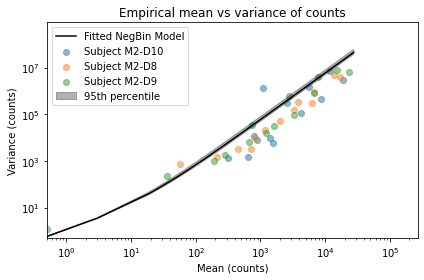

In [14]:
fig = md2.negbin.visualize_learned_negative_binomial_model(mcmc_negbin)
fig.tight_layout()

# Run the model

In [15]:
# Get a0 and a1 from negbin (get the mean of the posterior)
from mdsine2.names import STRNAMES
a0 = md2.summary(mcmc_negbin.graph[STRNAMES.NEGBIN_A0])['mean']
a1 = md2.summary(mcmc_negbin.graph[STRNAMES.NEGBIN_A1])['mean']

print('negbin a0', a0)
print('negbin a1', a1)

basepath = 'output/mdsine2/uc0'
os.makedirs(basepath, exist_ok=True)


# Initialize parameters of the model
params = md2.config.MDSINE2ModelConfig(
    basepath=basepath, seed=0, burnin=50, 
    n_samples=100, negbin_a0=a0, negbin_a1=a1, checkpoint=50)

# The default number of modules is 30, which is larger than the number of taxa
# that we have in this dataset, which would throw a flag.
params.INITIALIZATION_KWARGS[STRNAMES.CLUSTERING]['value_option'] = 'no-clusters'

negbin a0 1.1642672989308661e-13
negbin a1 0.05972242507901712


In [16]:
# initilize the graph
mcmc_uc0 = md2.initialize_graph(params=params, graph_name=uc_toy.name, subjset=uc_toy)


INFO:base.2534: max_value found: 1797837340792.1643, scaling_factor: 5.5622384590108656e-11
INFO:run.84: Normalizing abundances for a max value of 100. Normalization constant: 5.5622E-11
INFO:run.251: There are 372 qPCR measurements for 3 buckets. Each bucket is 124 measurements long
INFO:run.286: Initializing Filtering
INFO:posterior.2659: Setting up the essential timepoints
INFO:posterior.2672: Essential timepoints: [ 1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   6.   7.   8.   9.  10.  11.  14.  16.  18.  21.  21.5 22.  22.5 23.  23.5 24.  25.  28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  33.  35.  35.5 36.  36.5 37.  37.5 38.  39.  42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  47.  50.  50.5 51.  51.5 52.  52.5 53.  54.  57.  57.5 58.  58.5 59.  59.5 60.  60.5 61.  62.  63.  64.  64.5]
INFO:run.286: Initializing Zero inflation
INFO:design_matrices.847: Initializing LHS vector
INFO:design_matrices.1012: Initializing growth design matrix
INFO:design_matrices.940: Initializing self-inte

INFO:run.371: 		prior.loc: 0
INFO:run.369: 	perturbation Vancomycin
INFO:run.370: 		value: {100115: 0, 100116: 0, 100117: 0, 100118: 0, 100119: 0, 100120: 0, 100121: 0, 100122: 0, 100123: 0, 100124: 0, 100125: 0, 100126: 0, 100127: 0, 100128: 0, 100129: 0}
INFO:run.371: 		prior.loc: 0
INFO:run.369: 	perturbation Gentamicin
INFO:run.370: 		value: {100115: 0, 100116: 0, 100117: 0, 100118: 0, 100119: 0, 100120: 0, 100121: 0, 100122: 0, 100123: 0, 100124: 0, 100125: 0, 100126: 0, 100127: 0, 100128: 0, 100129: 0}
INFO:run.371: 		prior.loc: 0
INFO:run.372: Perturbation prior variances:
INFO:run.374: 		dof: 2.5
INFO:run.375: 		scale: 2000.0
INFO:run.376: 		value: 10000.0
INFO:run.374: 		dof: 2.5
INFO:run.375: 		scale: 2000.0
INFO:run.376: 		value: 10000.0
INFO:run.374: 		dof: 2.5
INFO:run.375: 		scale: 2000.0
INFO:run.376: 		value: 10000.0
INFO:run.377: Perturbation indicators:
INFO:run.380: 	perturbation High Fat Diet: [False False False False False False False False False False False False 

In [17]:
mcmc_uc0 = md2.run_graph(mcmc_uc0, crash_if_error=True)

INFO:inference.430: 

Inference iteration 0/100, time: 0.0
INFO:inference.439: Cluster interaction indicator parameter: None
INFO:inference.439: Cluster interaction probability: 0.09234190994988938
INFO:inference.439: Perturbation indicator parameter: Perturbation Indicators - time: Nones
perturbation High Fat Diet (0/15): [False False False False False False False False False False False False False False False]
perturbation Vancomycin (0/15): [False False False False False False False False False False False False False False False]
perturbation Gentamicin (0/15): [False False False False False False False False False False False False False False False]
INFO:inference.439: Probability parameter for the beta prior of the perturbation indicator parameter: Perturbation Indicator probabilities
	perturbation High Fat Diet: 0.1527842458791451
	perturbation Vancomycin: 0.1527842458791451
	perturbation Gentamicin: 0.1527842458791451
INFO:inference.439: Logistic growth parameters (growth, se

INFO:inference.439: Mean parameter for the normal prior of the interaction parameter: 9.483892334955561
INFO:inference.439: Mean parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Means
	perturbation High Fat Diet: -5.633760869066583
	perturbation Vancomycin: -32.394691549238026
	perturbation Gentamicin: 19.22092898194378
INFO:inference.439: Mean parameter for the truncated normal prior of the growth parameter: Value: 1.155360661555971, Acceptance rate: 1.0
INFO:inference.439: Mean parameter for the truncated normal prior of the self-interaction parameter: Value: 0.7886622384767377, Acceptance rate: 1.0
INFO:inference.439: Variance parameter for the normal prior of the interaction parameter: 4047.7156572959684
INFO:inference.439: Variance parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Variances
	perturbation High Fat Diet: 204.06655221025355
	perturbation Vancomycin: 1115.7342315369867
	perturbation Gen

INFO:inference.439: Cluster interaction probability: 0.06389609988570996
INFO:inference.439: Perturbation indicator parameter: Perturbation Indicators - time: 0.015000343322753906s
perturbation High Fat Diet (1/15): [False False False False False  True False False False False False False False False False]
perturbation Vancomycin (2/15): [False False False False False False False False  True False False False  True False False]
perturbation Gentamicin (2/15): [False False False False False False False  True False False False False  True False False]
INFO:inference.439: Probability parameter for the beta prior of the perturbation indicator parameter: Perturbation Indicator probabilities
	perturbation High Fat Diet: 0.025066240399094393
	perturbation Vancomycin: 0.09438846925304158
	perturbation Gentamicin: 0.311140162497224
INFO:inference.439: Logistic growth parameters (growth, self-interactions, interactions/perturbations): Growth:
[0.05133125 0.35152011 0.35811711 0.31745151 0.483465

INFO:inference.439: Clustering concentration parameter: 2548.488953421099
INFO:posterior.1579: 0/15: 0
INFO:posterior.1579: 1/15: 13
INFO:posterior.1579: 2/15: 14
INFO:posterior.1579: 3/15: 4
INFO:posterior.1579: 4/15: 6
INFO:posterior.1579: 5/15: 8
INFO:posterior.1579: 6/15: 10
INFO:posterior.1579: 7/15: 7
INFO:posterior.1579: 8/15: 1
INFO:posterior.1579: 9/15: 9
INFO:posterior.1579: 10/15: 12
INFO:posterior.1579: 11/15: 2
INFO:posterior.1579: 12/15: 3
INFO:posterior.1579: 13/15: 11
INFO:posterior.1579: 14/15: 5
INFO:inference.430: 

Inference iteration 5/100, time: 0.9120001792907715
INFO:inference.439: Cluster interaction indicator parameter: [False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False Fal

INFO:inference.439: Mean parameter for the normal prior of the interaction parameter: 5.710958952384468
INFO:inference.439: Mean parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Means
	perturbation High Fat Diet: 38.518554822402024
	perturbation Vancomycin: 35.59433820706934
	perturbation Gentamicin: -1.776905185472492
INFO:inference.439: Mean parameter for the truncated normal prior of the growth parameter: Value: 1.1500028442148336, Acceptance rate: 1.0
INFO:inference.439: Mean parameter for the truncated normal prior of the self-interaction parameter: Value: 0.47231404103632385, Acceptance rate: 1.0
INFO:inference.439: Variance parameter for the normal prior of the interaction parameter: 235.123399281476
INFO:inference.439: Variance parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Variances
	perturbation High Fat Diet: 1373.5156501035844
	perturbation Vancomycin: 1947.4789233029717
	perturbation Gent

INFO:inference.439: Cluster interaction probability: 0.01414955107963672
INFO:inference.439: Perturbation indicator parameter: Perturbation Indicators - time: 0.011999845504760742s
perturbation High Fat Diet (0/15): [False False False False False False False False False False False False False False False]
perturbation Vancomycin (2/15): [False  True False False False False False False False False  True False False False False]
perturbation Gentamicin (0/15): [False False False False False False False False False False False False False False False]
INFO:inference.439: Probability parameter for the beta prior of the perturbation indicator parameter: Perturbation Indicator probabilities
	perturbation High Fat Diet: 0.04380913321868082
	perturbation Vancomycin: 0.2668272055717504
	perturbation Gentamicin: 0.00015348561567036495
INFO:inference.439: Logistic growth parameters (growth, self-interactions, interactions/perturbations): Growth:
[0.43325582 0.30910204 0.47357585 0.11244414 0.662

INFO:inference.439: Filtering: no-mp - Time: 0.2610, Acc: [0.620, 0.638, 0.609, 0.638, 0.603], data/sec: 21551.67
INFO:inference.439: Clustering parameter: Clustering object (contains ability to change the cluster assignments), n_clusters: 15
Cluster 100156
	members: ['OTU_4']
	size: 1
Cluster 100158
	members: ['OTU_6']
	size: 1
Cluster 100160
	members: ['OTU_8']
	size: 1
Cluster 100161
	members: ['OTU_13']
	size: 1
Cluster 100162
	members: ['OTU_1']
	size: 1
Cluster 100163
	members: ['OTU_3']
	size: 1
Cluster 100165
	members: ['OTU_7']
	size: 1
Cluster 100166
	members: ['OTU_9']
	size: 1
Cluster 100168
	members: ['OTU_17']
	size: 1
Cluster 100170
	members: ['OTU_5']
	size: 1
Cluster 100172
	members: ['OTU_16']
	size: 1
Cluster 100174
	members: ['OTU_10']
	size: 1
Cluster 100175
	members: ['OTU_12']
	size: 1
Cluster 100177
	members: ['OTU_18']
	size: 1
Cluster 100179
	members: ['OTU_2']
	size: 1
no mp - Total time: 0.5239999294281006
INFO:inference.439: Clustering concentration paramet

INFO:inference.439: Probability parameter for the beta prior of the perturbation indicator parameter: Perturbation Indicator probabilities
	perturbation High Fat Diet: 0.02424975560847808
	perturbation Vancomycin: 0.2318151062030672
	perturbation Gentamicin: 0.0196823200422439
INFO:inference.439: Logistic growth parameters (growth, self-interactions, interactions/perturbations): Growth:
[0.77828705 0.38903905 0.76961277 0.10587474 0.59827022 0.6681632  0.21076414 0.44212117 0.02597526 0.17506687 0.38629987 0.1788002  0.67657752 0.52187184 0.20594952]
Self Interactions:
[ 0.36838934  0.24731934  0.20578355  0.47505948  0.84491244  0.55085404  1.62945113  1.36630626 87.39449338 99.34047228  1.77221516 51.90245568  4.80856796  2.17100663  2.53311716]
Interactions:
[-0.7848822 -1.5365928]
Perturbations:
Perturbation Magnitudes (multiplicative)
	 perturbation High Fat Diet: []
	 perturbation Vancomycin: [-2.4466524  -2.55542478]
	 perturbation Gentamicin: []
INFO:inference.439: Mean paramet

INFO:inference.439: Clustering concentration parameter: 46196.9865769058
INFO:posterior.1579: 0/15: 7
INFO:posterior.1579: 1/15: 3
INFO:posterior.1579: 2/15: 12
INFO:posterior.1579: 3/15: 0
INFO:posterior.1579: 4/15: 11
INFO:posterior.1579: 5/15: 5
INFO:posterior.1579: 6/15: 8
INFO:posterior.1579: 7/15: 2
INFO:posterior.1579: 8/15: 9
INFO:posterior.1579: 9/15: 4
INFO:posterior.1579: 10/15: 1
INFO:posterior.1579: 11/15: 13
INFO:posterior.1579: 12/15: 6
INFO:posterior.1579: 13/15: 10
INFO:posterior.1579: 14/15: 14
INFO:inference.430: 

Inference iteration 13/100, time: 0.8799669742584229
INFO:inference.439: Cluster interaction indicator parameter: [False False False False False False False False False False False False False False False False False False False False False False  True False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False Fal

INFO:inference.439: Mean parameter for the normal prior of the interaction parameter: 6.1340365274674795
INFO:inference.439: Mean parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Means
	perturbation High Fat Diet: -46.038793635473446
	perturbation Vancomycin: -68.52683201248524
	perturbation Gentamicin: 97.6005567085997
INFO:inference.439: Mean parameter for the truncated normal prior of the growth parameter: Value: 0.19204162144120313, Acceptance rate: 0.9285714285714286
INFO:inference.439: Mean parameter for the truncated normal prior of the self-interaction parameter: Value: 0.4716932146951434, Acceptance rate: 0.9285714285714286
INFO:inference.439: Variance parameter for the normal prior of the interaction parameter: 125.28553759886377
INFO:inference.439: Variance parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Variances
	perturbation High Fat Diet: 2127.3926028988553
	perturbation Vancomycin: 2708

INFO:inference.439: Cluster interaction probability: 0.013751177599541212
INFO:inference.439: Perturbation indicator parameter: Perturbation Indicators - time: 0.010999917984008789s
perturbation High Fat Diet (0/14): [False False False False False False False False False False False False False False]
perturbation Vancomycin (2/14): [False False  True False False False False False False False False  True False False]
perturbation Gentamicin (0/14): [False False False False False False False False False False False False False False]
INFO:inference.439: Probability parameter for the beta prior of the perturbation indicator parameter: Perturbation Indicator probabilities
	perturbation High Fat Diet: 0.0037604469149499806
	perturbation Vancomycin: 0.16984116920929612
	perturbation Gentamicin: 4.287775725041615e-06
INFO:inference.439: Logistic growth parameters (growth, self-interactions, interactions/perturbations): Growth:
[0.56607291 0.25307775 0.41920211 0.05634966 0.44375933 0.0940781

INFO:inference.439: Clustering parameter: Clustering object (contains ability to change the cluster assignments), n_clusters: 15
Cluster 100204
	members: ['OTU_1']
	size: 1
Cluster 100206
	members: ['OTU_13']
	size: 1
Cluster 100207
	members: ['OTU_6']
	size: 1
Cluster 100209
	members: ['OTU_18']
	size: 1
Cluster 100211
	members: ['OTU_7']
	size: 1
Cluster 100212
	members: ['OTU_5']
	size: 1
Cluster 100213
	members: ['OTU_4']
	size: 1
Cluster 100215
	members: ['OTU_17']
	size: 1
Cluster 100217
	members: ['OTU_2']
	size: 1
Cluster 100219
	members: ['OTU_16']
	size: 1
Cluster 100221
	members: ['OTU_8']
	size: 1
Cluster 100223
	members: ['OTU_12']
	size: 1
Cluster 100225
	members: ['OTU_3']
	size: 1
Cluster 100227
	members: ['OTU_9']
	size: 1
Cluster 100229
	members: ['OTU_10']
	size: 1
no mp - Total time: 0.5170004367828369
INFO:inference.439: Clustering concentration parameter: 3270.220016260282
INFO:inference.430: 

Inference iteration 18/100, time: 0.35899996757507324
INFO:inference.4

INFO:inference.439: Logistic growth parameters (growth, self-interactions, interactions/perturbations): Growth:
[0.29370246 0.38591378 0.18303771 0.02926764 0.70426002 0.1291165  0.30920011 0.37296189 0.07103688 0.15129718 0.55530364 0.28536917 0.54757863 0.64553485 0.4540806 ]
Self Interactions:
[  0.24768225   0.40205482   0.16374552   8.95587355   1.04247776   0.68944755   1.33575728   1.21051782 125.89356317  91.02571771   2.9179503   81.42438581   2.95497357   4.37810375   4.73845091]
Interactions:
[]
Perturbations:
Perturbation Magnitudes (multiplicative)
	 perturbation High Fat Diet: []
	 perturbation Vancomycin: [-4.15255926 -2.07334606]
	 perturbation Gentamicin: []
INFO:inference.439: Mean parameter for the normal prior of the interaction parameter: -13.026265366294602
INFO:inference.439: Mean parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Means
	perturbation High Fat Diet: -110.04810459747449
	perturbation Vancomycin: -30.579706048

INFO:posterior.1579: 7/15: 8
INFO:posterior.1579: 8/15: 2
INFO:posterior.1579: 9/15: 9
INFO:posterior.1579: 10/15: 11
INFO:posterior.1579: 11/15: 7
INFO:posterior.1579: 12/15: 12
INFO:posterior.1579: 13/15: 0
INFO:posterior.1579: 14/15: 5
INFO:inference.430: 

Inference iteration 21/100, time: 0.8659992218017578
INFO:inference.439: Cluster interaction indicator parameter: [False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False 

INFO:inference.439: Mean parameter for the normal prior of the interaction parameter: 27.652104631790984
INFO:inference.439: Mean parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Means
	perturbation High Fat Diet: -44.37818270744558
	perturbation Vancomycin: -21.383706518591907
	perturbation Gentamicin: -129.69452957321846
INFO:inference.439: Mean parameter for the truncated normal prior of the growth parameter: Value: 0.23744028888703927, Acceptance rate: 0.9545454545454546
INFO:inference.439: Mean parameter for the truncated normal prior of the self-interaction parameter: Value: 3.44840227843026, Acceptance rate: 0.9545454545454546
INFO:inference.439: Variance parameter for the normal prior of the interaction parameter: 39.162105384355
INFO:inference.439: Variance parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Variances
	perturbation High Fat Diet: 3535.408495278542
	perturbation Vancomycin: 1804.53

INFO:inference.439: Cluster interaction probability: 0.0008981278085360077
INFO:inference.439: Perturbation indicator parameter: Perturbation Indicators - time: 0.012000322341918945s
perturbation High Fat Diet (0/15): [False False False False False False False False False False False False False False False]
perturbation Vancomycin (3/15): [False False False False False  True False False False False False False  True False  True]
perturbation Gentamicin (0/15): [False False False False False False False False False False False False False False False]
INFO:inference.439: Probability parameter for the beta prior of the perturbation indicator parameter: Perturbation Indicator probabilities
	perturbation High Fat Diet: 0.056565665203912145
	perturbation Vancomycin: 0.1348478688877273
	perturbation Gentamicin: 0.0004915438369254233
INFO:inference.439: Logistic growth parameters (growth, self-interactions, interactions/perturbations): Growth:
[0.62734541 0.44127795 0.41481292 0.23076712 0.5

INFO:inference.439: Filtering: no-mp - Time: 0.2730, Acc: [0.632, 0.609, 0.648, 0.635, 0.600], data/sec: 20604.38
INFO:inference.439: Clustering parameter: Clustering object (contains ability to change the cluster assignments), n_clusters: 14
Cluster 100256
	members: ['OTU_2']
	size: 1
Cluster 100258
	members: ['OTU_9']
	size: 1
Cluster 100260
	members: ['OTU_3']
	size: 1
Cluster 100261
	members: ['OTU_7']
	size: 1
Cluster 100263
	members: ['OTU_12']
	size: 1
Cluster 100265
	members: ['OTU_17']
	size: 1
Cluster 100267
	members: ['OTU_4']
	size: 1
Cluster 100268
	members: ['OTU_18']
	size: 1
Cluster 100270
	members: ['OTU_8']
	size: 1
Cluster 100272
	members: ['OTU_1']
	size: 1
Cluster 100274
	members: ['OTU_10', 'OTU_6']
	size: 2
Cluster 100276
	members: ['OTU_13']
	size: 1
Cluster 100278
	members: ['OTU_16']
	size: 1
Cluster 100279
	members: ['OTU_5']
	size: 1
no mp - Total time: 0.5209999084472656
INFO:inference.439: Clustering concentration parameter: 31812.98023002288
INFO:inferenc

INFO:inference.439: Mean parameter for the normal prior of the interaction parameter: 216.0711656622921
INFO:inference.439: Mean parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Means
	perturbation High Fat Diet: 12.103465320243336
	perturbation Vancomycin: 36.95050187271609
	perturbation Gentamicin: -77.6411666680021
INFO:inference.439: Mean parameter for the truncated normal prior of the growth parameter: Value: 0.1724545927159885, Acceptance rate: 0.9629629629629629
INFO:inference.439: Mean parameter for the truncated normal prior of the self-interaction parameter: Value: 4.00528704708668, Acceptance rate: 0.9629629629629629
INFO:inference.439: Variance parameter for the normal prior of the interaction parameter: 432.4841388491492
INFO:inference.439: Variance parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Variances
	perturbation High Fat Diet: 1977.0526500756528
	perturbation Vancomycin: 1756.76028

INFO:inference.439: Cluster interaction probability: 0.008404940582929198
INFO:inference.439: Perturbation indicator parameter: Perturbation Indicators - time: 0.010993242263793945s
perturbation High Fat Diet (0/13): [False False False False False False False False False False False False False]
perturbation Vancomycin (1/13): [False False False False False  True False False False False False False False]
perturbation Gentamicin (1/13): [False False False False  True False False False False False False False False]
INFO:inference.439: Probability parameter for the beta prior of the perturbation indicator parameter: Perturbation Indicator probabilities
	perturbation High Fat Diet: 0.02142678933032397
	perturbation Vancomycin: 0.11757863916064848
	perturbation Gentamicin: 0.025899308693583364
INFO:inference.439: Logistic growth parameters (growth, self-interactions, interactions/perturbations): Growth:
[0.72190496 0.57119454 0.72178933 0.02099413 0.68982347 0.1611206  0.40493942 0.199613

INFO:inference.439: Clustering concentration parameter: 229.28960964489602
INFO:inference.430: 

Inference iteration 31/100, time: 0.355999231338501
INFO:inference.439: Cluster interaction indicator parameter: [False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False Fal

INFO:inference.439: Variance parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Variances
	perturbation High Fat Diet: 1911.5561420524598
	perturbation Vancomycin: 1048.485926238085
	perturbation Gentamicin: 16176.28324755816
INFO:inference.439: Process Variance parameter: 3.6245221040935434, empirical_variance: 3.54267
INFO:inference.439: Filtering: no-mp - Time: 0.2550, Acc: [0.627, 0.611, 0.631, 0.615, 0.613], data/sec: 22058.85
INFO:inference.439: Clustering parameter: Clustering object (contains ability to change the cluster assignments), n_clusters: 13
Cluster 100267
	members: ['OTU_2']
	size: 1
Cluster 100283
	members: ['OTU_16']
	size: 1
Cluster 100284
	members: ['OTU_1']
	size: 1
Cluster 100286
	members: ['OTU_13', 'OTU_10']
	size: 2
Cluster 100287
	members: ['OTU_4']
	size: 1
Cluster 100289
	members: ['OTU_8']
	size: 1
Cluster 100291
	members: ['OTU_3', 'OTU_18']
	size: 2
Cluster 100293
	members: ['OTU_7']
	size: 1
Cluster 100294
	membe

INFO:inference.439: Logistic growth parameters (growth, self-interactions, interactions/perturbations): Growth:
[0.69365478 0.4681807  0.80974323 0.23503787 0.42963151 0.62235426 0.19566671 0.38184099 0.23193871 0.20930173 0.57757694 0.1602437  0.79496203 0.60144929 0.61842047]
Self Interactions:
[  0.46284325   0.2856472    0.29904691   5.6000427    0.87449228   0.64369303   1.58086019   1.70824993 153.58397033 196.26046715   2.42600308  66.29202873   4.44181983   3.97301633   6.58354745]
Interactions:
[-0.27184924]
Perturbations:
Perturbation Magnitudes (multiplicative)
	 perturbation High Fat Diet: []
	 perturbation Vancomycin: [-2.55970475 -2.48285028]
	 perturbation Gentamicin: []
INFO:inference.439: Mean parameter for the normal prior of the interaction parameter: -0.9175746763015655
INFO:inference.439: Mean parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Means
	perturbation High Fat Diet: -98.9223609485391
	perturbation Vancomycin: 5.39

INFO:inference.439: Cluster interaction probability: 0.010019962649802453
INFO:inference.439: Perturbation indicator parameter: Perturbation Indicators - time: 0.009999513626098633s
perturbation High Fat Diet (0/12): [False False False False False False False False False False False False]
perturbation Vancomycin (2/12): [ True  True False False False False False False False False False False]
perturbation Gentamicin (0/12): [False False False False False False False False False False False False]
INFO:inference.439: Probability parameter for the beta prior of the perturbation indicator parameter: Perturbation Indicator probabilities
	perturbation High Fat Diet: 0.0055196428382226275
	perturbation Vancomycin: 0.08088376996341635
	perturbation Gentamicin: 0.009283658464158398
INFO:inference.439: Logistic growth parameters (growth, self-interactions, interactions/perturbations): Growth:
[0.67823459 0.45984652 0.83495316 0.32274834 0.61509206 0.69468169 0.39988257 0.56562717 0.24061606 0.

INFO:inference.439: Clustering concentration parameter: 15.34071160806143
INFO:inference.430: 

Inference iteration 38/100, time: 0.34199976921081543
INFO:inference.439: Cluster interaction indicator parameter: [False False False False False False False False False False False False  True False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False]
total time: 0.03800058364868164, n_interactions: 1/110, 0.01
INFO:inference.439: Cluster interaction probability: 0.01874427708

INFO:inference.439: Clustering concentration parameter: 28.75973797176516
INFO:inference.430: 

Inference iteration 40/100, time: 0.33300113677978516
INFO:inference.439: Cluster interaction indicator parameter: [False False False False False False False False False False False False  True False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False  True False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False]
total time: 0.03699898719787598, n_interactions: 2/110, 0.02
INFO:inference.439: Cluster interaction probability: 0.02259835608

INFO:inference.439: Process Variance parameter: 3.2777488333205897, empirical_variance: 3.30224
INFO:inference.439: Filtering: no-mp - Time: 0.2520, Acc: [0.628, 0.632, 0.629, 0.601, 0.599], data/sec: 22321.40
INFO:inference.439: Clustering parameter: Clustering object (contains ability to change the cluster assignments), n_clusters: 13
Cluster 100306
	members: ['OTU_6', 'OTU_17']
	size: 2
Cluster 100342
	members: ['OTU_4', 'OTU_12']
	size: 2
Cluster 100345
	members: ['OTU_9']
	size: 1
Cluster 100347
	members: ['OTU_3']
	size: 1
Cluster 100348
	members: ['OTU_13']
	size: 1
Cluster 100350
	members: ['OTU_16']
	size: 1
Cluster 100352
	members: ['OTU_10']
	size: 1
Cluster 100353
	members: ['OTU_1']
	size: 1
Cluster 100355
	members: ['OTU_7']
	size: 1
Cluster 100356
	members: ['OTU_8']
	size: 1
Cluster 100359
	members: ['OTU_5']
	size: 1
Cluster 100361
	members: ['OTU_18']
	size: 1
Cluster 100363
	members: ['OTU_2']
	size: 1
no mp - Total time: 0.4459998607635498
INFO:inference.439: Cluste

INFO:inference.439: Mean parameter for the normal prior of the interaction parameter: -7.717845280799569
INFO:inference.439: Mean parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Means
	perturbation High Fat Diet: 48.038800498666575
	perturbation Vancomycin: 7.461583932017077
	perturbation Gentamicin: 187.8553153027855
INFO:inference.439: Mean parameter for the truncated normal prior of the growth parameter: Value: 0.7561403902999988, Acceptance rate: 0.9534883720930233
INFO:inference.439: Mean parameter for the truncated normal prior of the self-interaction parameter: Value: 4.414960475362338, Acceptance rate: 0.9767441860465116
INFO:inference.439: Variance parameter for the normal prior of the interaction parameter: 234.11812254459113
INFO:inference.439: Variance parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Variances
	perturbation High Fat Diet: 3848.9144567762455
	perturbation Vancomycin: 516.528

INFO:inference.439: Cluster interaction probability: 0.0499169820929027
INFO:inference.439: Perturbation indicator parameter: Perturbation Indicators - time: 0.014000415802001953s
perturbation High Fat Diet (0/14): [False False False False False False False False False False False False False False]
perturbation Vancomycin (3/14): [ True False  True False False False  True False False False False False False False]
perturbation Gentamicin (0/14): [False False False False False False False False False False False False False False]
INFO:inference.439: Probability parameter for the beta prior of the perturbation indicator parameter: Perturbation Indicator probabilities
	perturbation High Fat Diet: 0.002189390859266743
	perturbation Vancomycin: 0.3293227241042134
	perturbation Gentamicin: 0.01640935982992784
INFO:inference.439: Logistic growth parameters (growth, self-interactions, interactions/perturbations): Growth:
[0.62970117 0.13444772 0.75312494 0.15043003 0.64959174 0.48351938 0.26

INFO:inference.439: Clustering concentration parameter: 167.85474577320244
INFO:inference.430: 

Inference iteration 47/100, time: 0.37000012397766113
INFO:inference.439: Cluster interaction indicator parameter: [False False False False False False False False  True False False False False False False False False False False False False False False False False False False False  True False False False False False False False False False False False False False False False False False False False False False False False False  True False  True False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False  True False False False False False False False False False False False False False False  True False False False False False False False False False False False False False False False  True False False False False False False False F

INFO:inference.439: Mean parameter for the truncated normal prior of the growth parameter: Value: 0.6530050194723781, Acceptance rate: 0.9583333333333334
INFO:inference.439: Mean parameter for the truncated normal prior of the self-interaction parameter: Value: 5.028015165228264, Acceptance rate: 0.9791666666666666
INFO:inference.439: Variance parameter for the normal prior of the interaction parameter: 1700.1345579200354
INFO:inference.439: Variance parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Variances
	perturbation High Fat Diet: 3468.6276524218583
	perturbation Vancomycin: 4615.7517047354395
	perturbation Gentamicin: 6311.954998707005
INFO:inference.439: Process Variance parameter: 3.122341694909778, empirical_variance: 3.14603
INFO:inference.439: Filtering: no-mp - Time: 0.2550, Acc: [0.612, 0.615, 0.633, 0.610, 0.614], data/sec: 22058.77
INFO:inference.439: Clustering parameter: Clustering object (contains ability to change the cluste

INFO:inference.439: Cluster interaction probability: 0.05970816329349733
INFO:inference.439: Perturbation indicator parameter: Perturbation Indicators - time: 0.013993263244628906s
perturbation High Fat Diet (0/13): [False False False False False False False False False False False False False]
perturbation Vancomycin (1/13): [ True False False False False False False False False False False False False]
perturbation Gentamicin (0/13): [False False False False False False False False False False False False False]
INFO:inference.439: Probability parameter for the beta prior of the perturbation indicator parameter: Perturbation Indicator probabilities
	perturbation High Fat Diet: 0.01610666860058421
	perturbation Vancomycin: 0.014636698232858535
	perturbation Gentamicin: 0.0007642645604091442
INFO:inference.439: Logistic growth parameters (growth, self-interactions, interactions/perturbations): Growth:
[0.60769308 0.32504927 0.58488658 0.25408581 0.57834118 0.56531363 0.82844725 0.34901

INFO:inference.439: Clustering concentration parameter: 25.01986315127886
INFO:inference.430: 

Inference iteration 52/100, time: 0.36701393127441406
INFO:inference.439: Cluster interaction indicator parameter: [False  True False False False False False False False False False False False False False False False False False False  True False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False  True False False False False False False False False  True False False  True False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False  True False Fa

INFO:inference.439: Mean parameter for the truncated normal prior of the growth parameter: Value: 0.23350775446399574, Acceptance rate: 0.96
INFO:inference.439: Mean parameter for the truncated normal prior of the self-interaction parameter: Value: 6.662571729713365, Acceptance rate: 0.98
INFO:inference.439: Variance parameter for the normal prior of the interaction parameter: 2378.170773148202
INFO:inference.439: Variance parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Variances
	perturbation High Fat Diet: 8868.51818703299
	perturbation Vancomycin: 37256.377644717395
	perturbation Gentamicin: 9406.56809747608
INFO:inference.439: Process Variance parameter: 2.8568651876071316, empirical_variance: 2.90207
INFO:inference.439: Filtering: no-mp - Time: 0.2770, Acc: [0.647, 0.628, 0.621, 0.600, 0.595], data/sec: 20306.86
INFO:inference.439: Clustering parameter: Clustering object (contains ability to change the cluster assignments), n_clusters: 13

INFO:inference.439: Probability parameter for the beta prior of the perturbation indicator parameter: Perturbation Indicator probabilities
	perturbation High Fat Diet: 0.02661889958097562
	perturbation Vancomycin: 0.3556482647379822
	perturbation Gentamicin: 0.0008265788619145001
INFO:inference.439: Logistic growth parameters (growth, self-interactions, interactions/perturbations): Growth:
[0.44108532 0.45273117 0.58964431 0.33305507 0.72633823 0.88708654 0.49223344 0.50273029 0.37209497 0.04333768 0.51876258 0.18577441 1.15059718 0.93856449 0.36318686]
Self Interactions:
[3.56458408e-01 2.72560724e-01 3.08849433e-01 2.10188813e+00 1.48356241e+00 4.74665583e-01 8.52728946e-01 1.59027260e+00 3.22417545e+02 2.15794796e+02 2.10743967e+00 9.71568903e+01 3.50855632e+00 3.72412763e+00 4.19418915e+00]
Interactions:
[ -0.23492287 -63.94281668 -85.44841274  -0.41951026 -59.48595247  16.62438204 -91.66006103]
Perturbations:
Perturbation Magnitudes (multiplicative)
	 perturbation High Fat Diet: [

INFO:posterior.1579: 6/15: 6
INFO:posterior.1579: 7/15: 2
INFO:posterior.1579: 8/15: 14
INFO:posterior.1579: 9/15: 4
INFO:posterior.1579: 10/15: 13
INFO:posterior.1579: 11/15: 10
INFO:posterior.1579: 12/15: 0
INFO:posterior.1579: 13/15: 9
INFO:posterior.1579: 14/15: 12
INFO:inference.430: 

Inference iteration 57/100, time: 0.7820010185241699
INFO:inference.439: Cluster interaction indicator parameter: [False  True False False False False False False False False False False False False False  True False False False False False False False False False False False  True False False False False False False False False False False False False False False False False False  True False False False False False False False False False False False False False False False False  True False False False False False False  True False False False False False False  True False False False False False False False False False False False False False False False False False False False False False False

INFO:inference.439: Variance parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Variances
	perturbation High Fat Diet: 833.8398140167304
	perturbation Vancomycin: 2335.488499820974
	perturbation Gentamicin: 600.0012880637872
INFO:inference.439: Process Variance parameter: 2.727382866016019, empirical_variance: 2.75150
INFO:inference.439: Filtering: no-mp - Time: 0.2770, Acc: [0.616, 0.610, 0.612, 0.612, 0.620], data/sec: 20306.79
INFO:inference.439: Clustering parameter: Clustering object (contains ability to change the cluster assignments), n_clusters: 11
Cluster 100306
	members: ['OTU_6', 'OTU_7', 'OTU_17', 'OTU_16']
	size: 4
Cluster 100422
	members: ['OTU_4']
	size: 1
Cluster 100435
	members: ['OTU_9']
	size: 1
Cluster 100437
	members: ['OTU_13']
	size: 1
Cluster 100439
	members: ['OTU_2']
	size: 1
Cluster 100443
	members: ['OTU_8']
	size: 1
Cluster 100446
	members: ['OTU_3']
	size: 1
Cluster 100447
	members: ['OTU_18', 'OTU_5']
	size: 2
Clust

INFO:inference.439: Mean parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Means
	perturbation High Fat Diet: 142.49318051218776
	perturbation Vancomycin: -9.339611811059374
	perturbation Gentamicin: 209.83155114509762
INFO:inference.439: Mean parameter for the truncated normal prior of the growth parameter: Value: 0.3653723292633788, Acceptance rate: 0.94
INFO:inference.439: Mean parameter for the truncated normal prior of the self-interaction parameter: Value: 5.7373255098705656, Acceptance rate: 1.0
INFO:inference.439: Variance parameter for the normal prior of the interaction parameter: 2137.9592511965648
INFO:inference.439: Variance parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Variances
	perturbation High Fat Diet: 51320.02899250236
	perturbation Vancomycin: 2269.3298334321266
	perturbation Gentamicin: 1085.5334950637473
INFO:inference.439: Process Variance parameter: 2.6816700065942016, empiric

INFO:inference.439: Mean parameter for the normal prior of the interaction parameter: -42.60206871601578
INFO:inference.439: Mean parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Means
	perturbation High Fat Diet: 91.71350860592803
	perturbation Vancomycin: -84.97878952423378
	perturbation Gentamicin: -79.94307428339097
INFO:inference.439: Mean parameter for the truncated normal prior of the growth parameter: Value: 0.6841325195592639, Acceptance rate: 0.96
INFO:inference.439: Mean parameter for the truncated normal prior of the self-interaction parameter: Value: 4.8857914636557105, Acceptance rate: 1.0
INFO:inference.439: Variance parameter for the normal prior of the interaction parameter: 740.6687918739885
INFO:inference.439: Variance parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Variances
	perturbation High Fat Diet: 2433.3665096511595
	perturbation Vancomycin: 3274.1995571166844
	perturbation Ge

INFO:inference.439: Mean parameter for the truncated normal prior of the self-interaction parameter: Value: 4.940652561724175, Acceptance rate: 1.0
INFO:inference.439: Variance parameter for the normal prior of the interaction parameter: 67.27787752680678
INFO:inference.439: Variance parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Variances
	perturbation High Fat Diet: 7083.4424133845105
	perturbation Vancomycin: 791.2595932937634
	perturbation Gentamicin: 901.1979323471468
INFO:inference.439: Process Variance parameter: 2.82506823944121, empirical_variance: 2.72639
INFO:inference.439: Filtering: no-mp - Time: 0.2750, Acc: [0.625, 0.623, 0.610, 0.597, 0.644], data/sec: 20454.50
INFO:inference.439: Clustering parameter: Clustering object (contains ability to change the cluster assignments), n_clusters: 8
Cluster 100306
	members: ['OTU_7', 'OTU_16', 'OTU_6', 'OTU_17']
	size: 4
Cluster 100446
	members: ['OTU_18']
	size: 1
Cluster 100450
	members:

INFO:inference.439: Variance parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Variances
	perturbation High Fat Diet: 4185.730309091
	perturbation Vancomycin: 1926.9646025477186
	perturbation Gentamicin: 1944.6291363194382
INFO:inference.439: Process Variance parameter: 2.799553427613666, empirical_variance: 2.71830
INFO:inference.439: Filtering: no-mp - Time: 0.2681, Acc: [0.633, 0.628, 0.624, 0.604, 0.613], data/sec: 20983.08
INFO:inference.439: Clustering parameter: Clustering object (contains ability to change the cluster assignments), n_clusters: 7
Cluster 100306
	members: ['OTU_17', 'OTU_6', 'OTU_16', 'OTU_7']
	size: 4
Cluster 100450
	members: ['OTU_8', 'OTU_12']
	size: 2
Cluster 100460
	members: ['OTU_5', 'OTU_3', 'OTU_2', 'OTU_13', 'OTU_9']
	size: 5
Cluster 100470
	members: ['OTU_10']
	size: 1
Cluster 100482
	members: ['OTU_4']
	size: 1
Cluster 100484
	members: ['OTU_18']
	size: 1
Cluster 100486
	members: ['OTU_1']
	size: 1
no mp - Total

INFO:inference.439: Clustering concentration parameter: 6.721868149321522
INFO:posterior.1579: 0/15: 10
INFO:posterior.1579: 1/15: 5
INFO:posterior.1579: 2/15: 12
INFO:posterior.1579: 3/15: 1
INFO:posterior.1579: 4/15: 14
INFO:posterior.1579: 5/15: 0
INFO:posterior.1579: 6/15: 13
INFO:posterior.1579: 7/15: 8
INFO:posterior.1579: 8/15: 4
INFO:posterior.1579: 9/15: 3
INFO:posterior.1579: 10/15: 9
INFO:posterior.1579: 11/15: 6
INFO:posterior.1579: 12/15: 11
INFO:posterior.1579: 13/15: 7
INFO:posterior.1579: 14/15: 2
INFO:inference.430: 

Inference iteration 69/100, time: 0.6000416278839111
INFO:inference.439: Cluster interaction indicator parameter: [ True False False False False False False False False False False False False False False False False False False False False False False False False False False  True False False False False False  True False False False False False  True False False]
total time: 0.021002531051635742, n_interactions: 4/42, 0.10
INFO:inference.439: Cluster in

INFO:inference.439: Clustering concentration parameter: 9.151992762607879
INFO:inference.430: 

Inference iteration 71/100, time: 0.32200050354003906
INFO:inference.439: Cluster interaction indicator parameter: [ True False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False  True False False False False False False False False False False False False False False False False False]
total time: 0.028000354766845703, n_interactions: 2/72, 0.03
INFO:inference.439: Cluster interaction probability: 0.023678071623027385
INFO:inference.439: Perturbation indicator parameter: Perturbation Indicators - time: 0.009000062942504883s
perturbation High Fat Diet (0/9): [False False False False False False False False False]
perturbation Vancomyci

INFO:posterior.1579: 5/15: 7
INFO:posterior.1579: 6/15: 4
INFO:posterior.1579: 7/15: 9
INFO:posterior.1579: 8/15: 3
INFO:posterior.1579: 9/15: 8
INFO:posterior.1579: 10/15: 2
INFO:posterior.1579: 11/15: 5
INFO:posterior.1579: 12/15: 10
INFO:posterior.1579: 13/15: 13
INFO:posterior.1579: 14/15: 0
INFO:inference.430: 

Inference iteration 73/100, time: 0.6180000305175781
INFO:inference.439: Cluster interaction indicator parameter: [ True False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False  True False False False False False False False False False False False False False False False False False]
total time: 0.025000333786010742, n_interactions: 2/72, 0.03
INFO:inference.439: Cluster interaction probability: 0.00551391239836480

INFO:inference.439: Cluster interaction probability: 0.09615629698599083
INFO:inference.439: Perturbation indicator parameter: Perturbation Indicators - time: 0.00800013542175293s
perturbation High Fat Diet (0/7): [False False False False False False False]
perturbation Vancomycin (2/7): [ True  True False False False False False]
perturbation Gentamicin (0/7): [False False False False False False False]
INFO:inference.439: Probability parameter for the beta prior of the perturbation indicator parameter: Perturbation Indicator probabilities
	perturbation High Fat Diet: 0.07055252547867205
	perturbation Vancomycin: 0.21679637208689612
	perturbation Gentamicin: 0.15943114513472303
INFO:inference.439: Logistic growth parameters (growth, self-interactions, interactions/perturbations): Growth:
[0.58180896 0.40364837 0.73268812 0.35314504 0.64892432 0.44836342 0.63747414 0.38092564 0.17957001 0.07750169 0.38696327 0.23151725 0.85152746 0.83222982 0.34934968]
Self Interactions:
[3.13420711e-0

INFO:inference.439: Probability parameter for the beta prior of the perturbation indicator parameter: Perturbation Indicator probabilities
	perturbation High Fat Diet: 0.05740909635727038
	perturbation Vancomycin: 0.11889499576280375
	perturbation Gentamicin: 0.12084489072900553
INFO:inference.439: Logistic growth parameters (growth, self-interactions, interactions/perturbations): Growth:
[0.51419088 0.55654982 0.83152267 0.21862966 0.8539318  0.42436684 0.47976834 0.25793995 0.30298533 0.12832345 0.48944029 0.31329093 0.69902029 1.05919132 0.39407051]
Self Interactions:
[4.38240831e-01 2.94735800e-01 3.53707205e-01 6.68934733e+00 1.18384933e+00 2.07713147e-01 7.89525940e-01 9.59882987e-01 2.08988306e+02 2.05262110e+02 2.81196662e+00 1.67083907e+02 2.51756908e+00 3.05547595e+00 4.02480033e+00]
Interactions:
[  -0.13247129 -118.56040454]
Perturbations:
Perturbation Magnitudes (multiplicative)
	 perturbation High Fat Diet: []
	 perturbation Vancomycin: [-1.06306372]
	 perturbation Gentam

INFO:inference.439: Mean parameter for the normal prior of the interaction parameter: -29.940750414982926
INFO:inference.439: Mean parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Means
	perturbation High Fat Diet: 78.02413459496853
	perturbation Vancomycin: -21.79152503631502
	perturbation Gentamicin: 14.851876101153549
INFO:inference.439: Mean parameter for the truncated normal prior of the growth parameter: Value: 0.41037951475537304, Acceptance rate: 0.94
INFO:inference.439: Mean parameter for the truncated normal prior of the self-interaction parameter: Value: 5.351567900249912, Acceptance rate: 0.98
INFO:inference.439: Variance parameter for the normal prior of the interaction parameter: 263.49239734214933
INFO:inference.439: Variance parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Variances
	perturbation High Fat Diet: 4357.852979956334
	perturbation Vancomycin: 1491.578462077849
	perturbation G

INFO:inference.439: Mean parameter for the truncated normal prior of the growth parameter: Value: 0.2644724587349503, Acceptance rate: 0.94
INFO:inference.439: Mean parameter for the truncated normal prior of the self-interaction parameter: Value: 5.174277792347437, Acceptance rate: 0.98
INFO:inference.439: Variance parameter for the normal prior of the interaction parameter: 442.5587272362454
INFO:inference.439: Variance parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Variances
	perturbation High Fat Diet: 2061.7603702440333
	perturbation Vancomycin: 3005.219386765508
	perturbation Gentamicin: 1573.9969729207437
INFO:inference.439: Process Variance parameter: 2.429143977377836, empirical_variance: 2.41527
INFO:inference.439: Filtering: no-mp - Time: 0.2505, Acc: [0.639, 0.612, 0.639, 0.624, 0.621], data/sec: 22454.52
INFO:inference.439: Clustering parameter: Clustering object (contains ability to change the cluster assignments), n_clusters: 7

INFO:inference.439: Filtering: no-mp - Time: 0.2510, Acc: [0.614, 0.614, 0.593, 0.640, 0.613], data/sec: 22410.64
INFO:inference.439: Clustering parameter: Clustering object (contains ability to change the cluster assignments), n_clusters: 7
Cluster 100306
	members: ['OTU_16', 'OTU_7', 'OTU_6', 'OTU_17']
	size: 4
Cluster 100504
	members: ['OTU_12', 'OTU_5', 'OTU_2']
	size: 3
Cluster 100517
	members: ['OTU_8', 'OTU_3']
	size: 2
Cluster 100530
	members: ['OTU_10', 'OTU_18', 'OTU_13']
	size: 3
Cluster 100545
	members: ['OTU_4']
	size: 1
Cluster 100548
	members: ['OTU_9']
	size: 1
Cluster 100558
	members: ['OTU_1']
	size: 1
no mp - Total time: 0.23800015449523926
INFO:inference.439: Clustering concentration parameter: 2.912980792429929
INFO:inference.430: 

Inference iteration 84/100, time: 0.30300021171569824
INFO:inference.439: Cluster interaction indicator parameter: [ True False  True False  True False False False False False  True False False False False False  True False False  True 

INFO:inference.439: Clustering concentration parameter: 1.476972424136275
INFO:inference.430: 

Inference iteration 86/100, time: 0.30900120735168457
INFO:inference.439: Cluster interaction indicator parameter: [ True False False False False False False False False False False False False False False False False False False False]
total time: 0.012016534805297852, n_interactions: 1/20, 0.05
INFO:inference.439: Cluster interaction probability: 0.1811227102791614
INFO:inference.439: Perturbation indicator parameter: Perturbation Indicators - time: 0.005982637405395508s
perturbation High Fat Diet (0/5): [False False False False False]
perturbation Vancomycin (1/5): [ True False False False False]
perturbation Gentamicin (1/5): [False False  True False False]
INFO:inference.439: Probability parameter for the beta prior of the perturbation indicator parameter: Perturbation Indicator probabilities
	perturbation High Fat Diet: 0.12897044933094862
	perturbation Vancomycin: 0.41788663021063804


INFO:inference.439: Mean parameter for the normal prior of the interaction parameter: -15.315378952399707
INFO:inference.439: Mean parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Means
	perturbation High Fat Diet: -86.02279764881698
	perturbation Vancomycin: -14.871550485458824
	perturbation Gentamicin: 7.176581086065954
INFO:inference.439: Mean parameter for the truncated normal prior of the growth parameter: Value: 0.048332522469662575, Acceptance rate: 0.96
INFO:inference.439: Mean parameter for the truncated normal prior of the self-interaction parameter: Value: 7.710923579708625, Acceptance rate: 0.98
INFO:inference.439: Variance parameter for the normal prior of the interaction parameter: 145.08058287185017
INFO:inference.439: Variance parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Variances
	perturbation High Fat Diet: 794.0614406469742
	perturbation Vancomycin: 3201.321533168586
	perturbation

INFO:inference.439: Process Variance parameter: 2.3666360213030675, empirical_variance: 2.33879
INFO:inference.439: Filtering: no-mp - Time: 0.2740, Acc: [0.613, 0.619, 0.612, 0.607, 0.610], data/sec: 20529.15
INFO:inference.439: Clustering parameter: Clustering object (contains ability to change the cluster assignments), n_clusters: 4
Cluster 100306
	members: ['OTU_16', 'OTU_6', 'OTU_17', 'OTU_7']
	size: 4
Cluster 100504
	members: ['OTU_2', 'OTU_12', 'OTU_10', 'OTU_4', 'OTU_1', 'OTU_9']
	size: 6
Cluster 100517
	members: ['OTU_8', 'OTU_3', 'OTU_5']
	size: 3
Cluster 100563
	members: ['OTU_18', 'OTU_13']
	size: 2
no mp - Total time: 0.18400001525878906
INFO:inference.439: Clustering concentration parameter: 0.2552207884434831
INFO:inference.430: 

Inference iteration 91/100, time: 0.3000469207763672
INFO:inference.439: Cluster interaction indicator parameter: [ True False False False False False False False False False False False]
total time: 0.007988452911376953, n_interactions: 1/12, 

INFO:inference.439: Cluster interaction probability: 0.010473475165487748
INFO:inference.439: Perturbation indicator parameter: Perturbation Indicators - time: 0.005001068115234375s
perturbation High Fat Diet (0/5): [False False False False False]
perturbation Vancomycin (2/5): [ True False False False  True]
perturbation Gentamicin (1/5): [False False  True False False]
INFO:inference.439: Probability parameter for the beta prior of the perturbation indicator parameter: Perturbation Indicator probabilities
	perturbation High Fat Diet: 0.007920894121977273
	perturbation Vancomycin: 0.2082716368850871
	perturbation Gentamicin: 0.15663296938069554
INFO:inference.439: Logistic growth parameters (growth, self-interactions, interactions/perturbations): Growth:
[0.55887976 0.50476287 0.71501496 0.11085446 0.48383508 0.72350223 0.3230901  0.52907524 0.00744005 0.05912055 0.77599871 0.20326607 1.0210944  0.85565753 0.51797642]
Self Interactions:
[3.22109276e-01 2.06196905e-01 2.50359954e-01 1.

INFO:inference.439: Mean parameter for the normal prior of the interaction parameter: 7.787418854172085
INFO:inference.439: Mean parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Means
	perturbation High Fat Diet: -55.20596928326981
	perturbation Vancomycin: 37.396533851143445
	perturbation Gentamicin: -23.0835245908347
INFO:inference.439: Mean parameter for the truncated normal prior of the growth parameter: Value: 0.08191619786164617, Acceptance rate: 0.96
INFO:inference.439: Mean parameter for the truncated normal prior of the self-interaction parameter: Value: 9.015086663381473, Acceptance rate: 0.98
INFO:inference.439: Variance parameter for the normal prior of the interaction parameter: 174.01108764353486
INFO:inference.439: Variance parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Variances
	perturbation High Fat Diet: 4048.820262435757
	perturbation Vancomycin: 3338.127990412214
	perturbation Gen

INFO:inference.439: Variance parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Variances
	perturbation High Fat Diet: 845.568176309266
	perturbation Vancomycin: 1971.5560611096585
	perturbation Gentamicin: 3912.77339812523
INFO:inference.439: Process Variance parameter: 2.299576744930418, empirical_variance: 2.36245
INFO:inference.439: Filtering: no-mp - Time: 0.2600, Acc: [0.602, 0.599, 0.590, 0.612, 0.624], data/sec: 21631.18
INFO:inference.439: Clustering parameter: Clustering object (contains ability to change the cluster assignments), n_clusters: 7
Cluster 100306
	members: ['OTU_7', 'OTU_17', 'OTU_6', 'OTU_16']
	size: 4
Cluster 100504
	members: ['OTU_1', 'OTU_12', 'OTU_9', 'OTU_2']
	size: 4
Cluster 100517
	members: ['OTU_8', 'OTU_10', 'OTU_3']
	size: 3
Cluster 100607
	members: ['OTU_5']
	size: 1
Cluster 100610
	members: ['OTU_13']
	size: 1
Cluster 100611
	members: ['OTU_4']
	size: 1
Cluster 100616
	members: ['OTU_18']
	size: 1
no mp - Total

INFO:inference.439: Clustering concentration parameter: 1.6851928331085522
INFO:inference.471: Inference total time: 0.44517448902130125/Gibb step
INFO:inference.475: remove local traces
INFO:run.544: Denormalizing the parameters


INFO:util.172: Number of clusters: 7
INFO:util.178: Clusters assigned: [0 0 4 1 6 3 3 4 0 1 0 5 3 3 2]


Cluster 0
	 Parasutterella excrementihominis OTU_5
Cluster 1
	 * Phocaeicola OTU_1
	 Bacteroides fragilis/ovatus OTU_2
	 * Bacteroides OTU_9
	 Parabacteroides distasonis OTU_12
Cluster 2
	 * Bacteroides OTU_4
	 Bacteroides uniformis OTU_10
Cluster 3
	 Parabacteroides merdae OTU_18
Cluster 4
	 Bacteroides fragilis/dorei OTU_6
	 Bacteroides caccae OTU_7
	 * Enterocloster OTU_16
	 Murimonas intestini OTU_17
Cluster 5
	 Akkermansia muciniphila OTU_3
	 Bacteroides salyersiae OTU_8
Cluster 6
	 Parabacteroides goldsteinii OTU_13


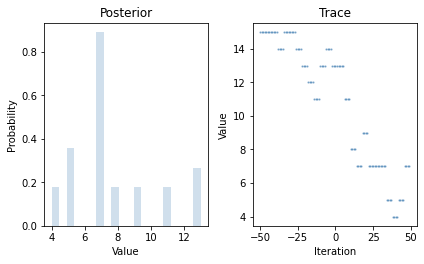

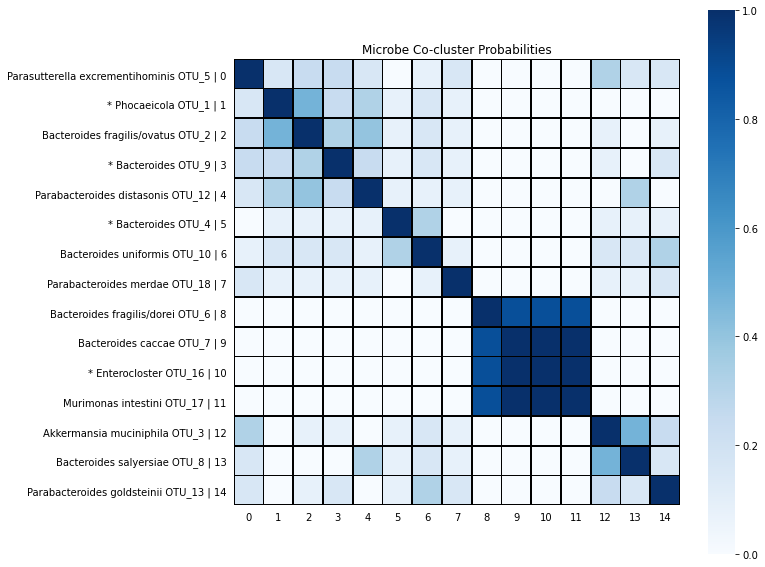

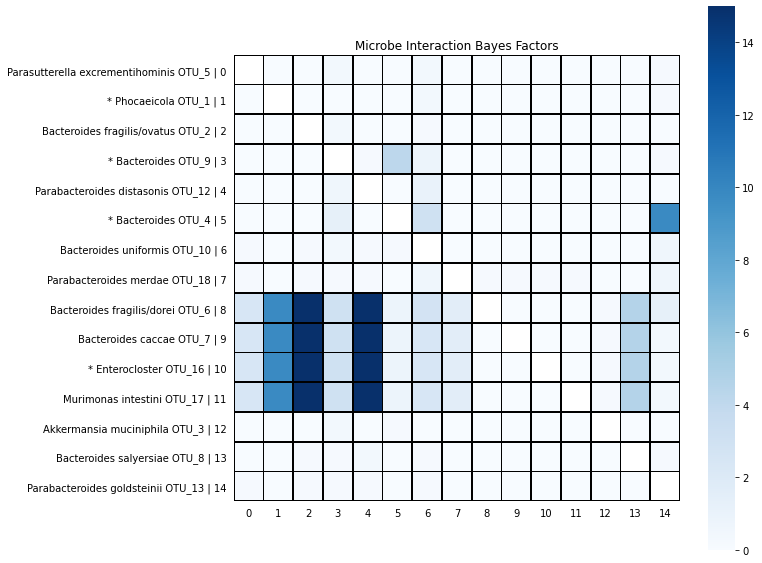

In [18]:
clustering = mcmc_uc0.graph[STRNAMES.CLUSTERING_OBJ]
md2.generate_cluster_assignments_posthoc(clustering, set_as_value=True)
taxas = mcmc_uc0.graph.data.taxas

md2.visualization.render_trace(clustering.n_clusters)
order = []
for i, cluster in enumerate(clustering):
    print('Cluster {}'.format(i))
    for oidx in cluster:
        print('\t', md2.taxaname_for_paper(taxas[oidx], taxas))
        order.append(oidx)

coclusters = md2.summary(mcmc_uc0.graph[STRNAMES.CLUSTERING_OBJ].coclusters)['mean']
md2.visualization.render_cocluster_proportions(coclusters, taxas=uc_toy.taxas,
    yticklabels='%(paperformat)s | %(index)s', order=order)

bayes_factors = md2.generate_interation_bayes_factors_posthoc(mcmc_uc0)
md2.visualization.render_bayes_factors(
    bayes_factors, taxas=taxas, yticklabels='%(paperformat)s | %(index)s',
    order=order)
plt.show()

# Calculating  $\hat{r}$

In [19]:
params = md2.config.MDSINE2ModelConfig(
    basepath='output/mdsine2/uc100', seed=100, burnin=50, 
    n_samples=100, negbin_a0=a0, negbin_a1=a1, 
    checkpoint=50)
params.INITIALIZATION_KWARGS[STRNAMES.CLUSTERING]['value_option'] = 'no-clusters'
mcmc_uc1 = md2.initialize_graph(params=params, graph_name=uc_toy.name, subjset=uc_toy)
mcmc_uc1 = md2.run_graph(mcmc_uc1, crash_if_error=True)


INFO:base.2534: max_value found: 1797837340792.1643, scaling_factor: 5.5622384590108656e-11
INFO:run.84: Normalizing abundances for a max value of 100. Normalization constant: 5.5622E-11
INFO:run.251: There are 372 qPCR measurements for 3 buckets. Each bucket is 124 measurements long
INFO:run.286: Initializing Filtering
INFO:posterior.2659: Setting up the essential timepoints
INFO:posterior.2672: Essential timepoints: [ 1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   6.   7.   8.   9.  10.  11.  14.  16.  18.  21.  21.5 22.  22.5 23.  23.5 24.  25.  28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  33.  35.  35.5 36.  36.5 37.  37.5 38.  39.  42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  47.  50.  50.5 51.  51.5 52.  52.5 53.  54.  57.  57.5 58.  58.5 59.  59.5 60.  60.5 61.  62.  63.  64.  64.5]
INFO:run.286: Initializing Zero inflation
INFO:design_matrices.847: Initializing LHS vector
INFO:design_matrices.1012: Initializing growth design matrix
INFO:design_matrices.940: Initializing self-inte

INFO:run.371: 		prior.loc: 0
INFO:run.369: 	perturbation Vancomycin
INFO:run.370: 		value: {100115: 0, 100116: 0, 100117: 0, 100118: 0, 100119: 0, 100120: 0, 100121: 0, 100122: 0, 100123: 0, 100124: 0, 100125: 0, 100126: 0, 100127: 0, 100128: 0, 100129: 0}
INFO:run.371: 		prior.loc: 0
INFO:run.369: 	perturbation Gentamicin
INFO:run.370: 		value: {100115: 0, 100116: 0, 100117: 0, 100118: 0, 100119: 0, 100120: 0, 100121: 0, 100122: 0, 100123: 0, 100124: 0, 100125: 0, 100126: 0, 100127: 0, 100128: 0, 100129: 0}
INFO:run.371: 		prior.loc: 0
INFO:run.372: Perturbation prior variances:
INFO:run.374: 		dof: 2.5
INFO:run.375: 		scale: 2000.0
INFO:run.376: 		value: 10000.0
INFO:run.374: 		dof: 2.5
INFO:run.375: 		scale: 2000.0
INFO:run.376: 		value: 10000.0
INFO:run.374: 		dof: 2.5
INFO:run.375: 		scale: 2000.0
INFO:run.376: 		value: 10000.0
INFO:run.377: Perturbation indicators:
INFO:run.380: 	perturbation High Fat Diet: [False False False False False False False False False False False False 

INFO:inference.439: Cluster interaction probability: 0.6902120211131538
INFO:inference.439: Perturbation indicator parameter: Perturbation Indicators - time: 0.026033639907836914s
perturbation High Fat Diet (9/15): [ True  True False  True False  True False  True  True  True False  True  True False False]
perturbation Vancomycin (11/15): [False  True False  True  True  True  True  True  True False  True False  True  True  True]
perturbation Gentamicin (11/15): [False  True  True False  True False False  True  True  True  True  True  True  True  True]
INFO:inference.439: Probability parameter for the beta prior of the perturbation indicator parameter: Perturbation Indicator probabilities
	perturbation High Fat Diet: 0.543380172150942
	perturbation Vancomycin: 0.6541798484844479
	perturbation Gentamicin: 0.5771423101278725
INFO:inference.439: Logistic growth parameters (growth, self-interactions, interactions/perturbations): Growth:
[0.12171643 0.39229091 0.74647098 0.36933789 0.76639724

INFO:inference.439: Probability parameter for the beta prior of the perturbation indicator parameter: Perturbation Indicator probabilities
	perturbation High Fat Diet: 0.24935488589151739
	perturbation Vancomycin: 0.39478510894188606
	perturbation Gentamicin: 0.0836243339418902
INFO:inference.439: Logistic growth parameters (growth, self-interactions, interactions/perturbations): Growth:
[0.02026563 0.20128539 0.7419323  0.02047319 0.73338937 0.55885879 0.23532478 0.36486274 0.17748172 0.30274626 0.0431157  0.29107326 1.28805679 0.72884907 0.17401487]
Self Interactions:
[9.18655524e-02 1.38047429e-01 2.27791916e-01 1.17697157e+00 1.51039381e+00 4.71091481e-01 2.61297844e-01 8.71438273e-01 6.35525406e+01 1.20543130e+02 1.51028935e-01 1.08117117e+02 4.55128167e+00 1.40742205e+00 4.37614901e+00]
Interactions:
[-9.32740112e+00  4.58207766e+01  6.39503961e-01 -3.69532773e+01 -3.87413142e+01 -6.39760566e-01  4.71188349e+00  1.06267818e+00  4.21912719e+00 -4.41174488e+01  9.84841289e-02 -4.64

INFO:inference.439: Process Variance parameter: 4.657837695315136, empirical_variance: 4.58982
INFO:inference.439: Filtering: no-mp - Time: 0.2540, Acc: [0.627, 0.596, 0.604, 0.618, 0.609], data/sec: 22145.65
INFO:inference.439: Clustering parameter: Clustering object (contains ability to change the cluster assignments), n_clusters: 15
Cluster 100115
	members: ['OTU_1']
	size: 1
Cluster 100116
	members: ['OTU_2']
	size: 1
Cluster 100117
	members: ['OTU_3']
	size: 1
Cluster 100118
	members: ['OTU_4']
	size: 1
Cluster 100119
	members: ['OTU_5']
	size: 1
Cluster 100120
	members: ['OTU_6']
	size: 1
Cluster 100121
	members: ['OTU_7']
	size: 1
Cluster 100122
	members: ['OTU_8']
	size: 1
Cluster 100123
	members: ['OTU_9']
	size: 1
Cluster 100124
	members: ['OTU_10']
	size: 1
Cluster 100125
	members: ['OTU_12']
	size: 1
Cluster 100126
	members: ['OTU_13']
	size: 1
Cluster 100127
	members: ['OTU_16']
	size: 1
Cluster 100128
	members: ['OTU_17']
	size: 1
Cluster 100129
	members: ['OTU_18']
	size

INFO:inference.439: Cluster interaction probability: 0.05671825787353486
INFO:inference.439: Perturbation indicator parameter: Perturbation Indicators - time: 0.013999462127685547s
perturbation High Fat Diet (2/14): [False False False  True False False False False False False False False  True False]
perturbation Vancomycin (3/14): [False False False False False  True False  True False False False  True False False]
perturbation Gentamicin (2/14): [False False False False False  True False False False False False False False  True]
INFO:inference.439: Probability parameter for the beta prior of the perturbation indicator parameter: Perturbation Indicator probabilities
	perturbation High Fat Diet: 0.08997769129193614
	perturbation Vancomycin: 0.10182442866807949
	perturbation Gentamicin: 0.13546862620523445
INFO:inference.439: Logistic growth parameters (growth, self-interactions, interactions/perturbations): Growth:
[0.23396469 0.05071815 0.56351721 0.05928085 0.59848133 0.81233107 0.3

INFO:inference.439: Clustering concentration parameter: 814.7881386996507
INFO:inference.430: 

Inference iteration 7/100, time: 0.3650186061859131
INFO:inference.439: Cluster interaction indicator parameter: [False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False  True False False False False  True False False False False False False False False False False False False  True False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False Fals

INFO:inference.439: Mean parameter for the truncated normal prior of the self-interaction parameter: Value: 0.681256760271574, Acceptance rate: 1.0
INFO:inference.439: Variance parameter for the normal prior of the interaction parameter: 19.204671279966163
INFO:inference.439: Variance parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Variances
	perturbation High Fat Diet: 4726.522475446529
	perturbation Vancomycin: 920.3966540624184
	perturbation Gentamicin: 2842.6896368211287
INFO:inference.439: Process Variance parameter: 4.57136289212544, empirical_variance: 4.49642
INFO:inference.439: Filtering: no-mp - Time: 0.2600, Acc: [0.620, 0.612, 0.616, 0.612, 0.589], data/sec: 21634.56
INFO:inference.439: Clustering parameter: Clustering object (contains ability to change the cluster assignments), n_clusters: 14
Cluster 100123
	members: ['OTU_1']
	size: 1
Cluster 100131
	members: ['OTU_2']
	size: 1
Cluster 100133
	members: ['OTU_8']
	size: 1
Cluster 

INFO:inference.439: Cluster interaction probability: 0.019219317008995093
INFO:inference.439: Perturbation indicator parameter: Perturbation Indicators - time: 0.013000249862670898s
perturbation High Fat Diet (0/15): [False False False False False False False False False False False False False False False]
perturbation Vancomycin (3/15): [False False False False False False False False False False  True False  True False  True]
perturbation Gentamicin (0/15): [False False False False False False False False False False False False False False False]
INFO:inference.439: Probability parameter for the beta prior of the perturbation indicator parameter: Perturbation Indicator probabilities
	perturbation High Fat Diet: 0.08808733362940692
	perturbation Vancomycin: 0.16548392662984784
	perturbation Gentamicin: 0.04465982534026625
INFO:inference.439: Logistic growth parameters (growth, self-interactions, interactions/perturbations): Growth:
[0.49198016 0.21030692 0.64095101 0.06186192 0.9454

INFO:inference.439: Clustering concentration parameter: 123.45332759751007
INFO:inference.430: 

Inference iteration 12/100, time: 0.35500001907348633
INFO:inference.439: Cluster interaction indicator parameter: [False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False F

INFO:inference.439: Mean parameter for the normal prior of the interaction parameter: -39.73152013243986
INFO:inference.439: Mean parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Means
	perturbation High Fat Diet: 116.09568866615393
	perturbation Vancomycin: -37.50588508882709
	perturbation Gentamicin: 8.101294681824909
INFO:inference.439: Mean parameter for the truncated normal prior of the growth parameter: Value: 1.015456397001164, Acceptance rate: 1.0
INFO:inference.439: Mean parameter for the truncated normal prior of the self-interaction parameter: Value: 0.6961580315156832, Acceptance rate: 1.0
INFO:inference.439: Variance parameter for the normal prior of the interaction parameter: 256.2391045076869
INFO:inference.439: Variance parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Variances
	perturbation High Fat Diet: 1261.8747107356699
	perturbation Vancomycin: 1155.826251096078
	perturbation Genta

INFO:inference.439: Cluster interaction probability: 0.002955667196838263
INFO:inference.439: Perturbation indicator parameter: Perturbation Indicators - time: 0.01100301742553711s
perturbation High Fat Diet (0/15): [False False False False False False False False False False False False False False False]
perturbation Vancomycin (2/15): [False False False False False False  True False  True False False False False False False]
perturbation Gentamicin (0/15): [False False False False False False False False False False False False False False False]
INFO:inference.439: Probability parameter for the beta prior of the perturbation indicator parameter: Perturbation Indicator probabilities
	perturbation High Fat Diet: 0.0027732186742285866
	perturbation Vancomycin: 0.04501046799959026
	perturbation Gentamicin: 0.026925721890679915
INFO:inference.439: Logistic growth parameters (growth, self-interactions, interactions/perturbations): Growth:
[0.731966   0.62211938 0.50895996 0.28300107 0.59

INFO:inference.439: Clustering concentration parameter: 1165.2744155930438
INFO:posterior.1579: 0/15: 5
INFO:posterior.1579: 1/15: 9
INFO:posterior.1579: 2/15: 1
INFO:posterior.1579: 3/15: 12
INFO:posterior.1579: 4/15: 11
INFO:posterior.1579: 5/15: 2
INFO:posterior.1579: 6/15: 4
INFO:posterior.1579: 7/15: 0
INFO:posterior.1579: 8/15: 14
INFO:posterior.1579: 9/15: 6
INFO:posterior.1579: 10/15: 7
INFO:posterior.1579: 11/15: 10
INFO:posterior.1579: 12/15: 3
INFO:posterior.1579: 13/15: 8
INFO:posterior.1579: 14/15: 13
INFO:inference.430: 

Inference iteration 17/100, time: 0.8698890209197998
INFO:inference.439: Cluster interaction indicator parameter: [False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False F

INFO:inference.439: Mean parameter for the normal prior of the interaction parameter: 164.83784441737384
INFO:inference.439: Mean parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Means
	perturbation High Fat Diet: 191.84530122374252
	perturbation Vancomycin: -23.32184666511523
	perturbation Gentamicin: 8.81076519990122
INFO:inference.439: Mean parameter for the truncated normal prior of the growth parameter: Value: 0.5910088523083559, Acceptance rate: 1.0
INFO:inference.439: Mean parameter for the truncated normal prior of the self-interaction parameter: Value: 0.6878226902925045, Acceptance rate: 1.0
INFO:inference.439: Variance parameter for the normal prior of the interaction parameter: 1071.6916904855088
INFO:inference.439: Variance parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Variances
	perturbation High Fat Diet: 8457.357307057138
	perturbation Vancomycin: 2452.0572350621806
	perturbation Gent

INFO:inference.439: Cluster interaction probability: 2.5329076092768128e-05
INFO:inference.439: Perturbation indicator parameter: Perturbation Indicators - time: 0.009999990463256836s
perturbation High Fat Diet (0/14): [False False False False False False False False False False False False False False]
perturbation Vancomycin (1/14): [False False False  True False False False False False False False False False False]
perturbation Gentamicin (0/14): [False False False False False False False False False False False False False False]
INFO:inference.439: Probability parameter for the beta prior of the perturbation indicator parameter: Perturbation Indicator probabilities
	perturbation High Fat Diet: 0.005722209083968403
	perturbation Vancomycin: 0.15117816274291745
	perturbation Gentamicin: 0.05765047417246074
INFO:inference.439: Logistic growth parameters (growth, self-interactions, interactions/perturbations): Growth:
[0.63076496 0.39140464 0.39605233 0.1826337  0.6800983  0.16595931

INFO:inference.439: Clustering concentration parameter: 52.3959774080807
INFO:inference.430: 

Inference iteration 22/100, time: 0.3489997386932373
INFO:inference.439: Cluster interaction indicator parameter: [False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False Fals

INFO:inference.439: Process Variance parameter: 3.656065568589099, empirical_variance: 3.77352
INFO:inference.439: Filtering: no-mp - Time: 0.2580, Acc: [0.628, 0.611, 0.632, 0.611, 0.650], data/sec: 21802.27
INFO:inference.439: Clustering parameter: Clustering object (contains ability to change the cluster assignments), n_clusters: 13
Cluster 100206
	members: ['OTU_16']
	size: 1
Cluster 100208
	members: ['OTU_17']
	size: 1
Cluster 100228
	members: ['OTU_4']
	size: 1
Cluster 100230
	members: ['OTU_3']
	size: 1
Cluster 100232
	members: ['OTU_2', 'OTU_12', 'OTU_18']
	size: 3
Cluster 100234
	members: ['OTU_8']
	size: 1
Cluster 100237
	members: ['OTU_9']
	size: 1
Cluster 100240
	members: ['OTU_7']
	size: 1
Cluster 100241
	members: ['OTU_6']
	size: 1
Cluster 100243
	members: ['OTU_5']
	size: 1
Cluster 100244
	members: ['OTU_1']
	size: 1
Cluster 100245
	members: ['OTU_10']
	size: 1
Cluster 100247
	members: ['OTU_13']
	size: 1
no mp - Total time: 0.451000452041626
INFO:inference.439: Clusteri

INFO:inference.439: Mean parameter for the normal prior of the interaction parameter: -142.266029284663
INFO:inference.439: Mean parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Means
	perturbation High Fat Diet: -51.473620951906405
	perturbation Vancomycin: -3.1953443092369618
	perturbation Gentamicin: -77.977803837417
INFO:inference.439: Mean parameter for the truncated normal prior of the growth parameter: Value: 1.0902924642206993, Acceptance rate: 1.0
INFO:inference.439: Mean parameter for the truncated normal prior of the self-interaction parameter: Value: 1.0826984967668232, Acceptance rate: 1.0
INFO:inference.439: Variance parameter for the normal prior of the interaction parameter: 34.203464062238275
INFO:inference.439: Variance parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Variances
	perturbation High Fat Diet: 3127.341727663292
	perturbation Vancomycin: 1123.1072082903045
	perturbation Gen

INFO:inference.439: Logistic growth parameters (growth, self-interactions, interactions/perturbations): Growth:
[0.44596749 0.43212157 0.22446266 0.17393508 0.63640629 0.24232414 0.37644446 0.61567717 0.04420426 0.11617067 0.56514483 0.22090738 0.70027598 0.61569529 0.09429326]
Self Interactions:
[4.07155325e-01 3.35771091e-01 1.67345382e-01 4.90475353e+00 1.08253226e+00 7.18232282e-01 1.80920770e+00 1.70110206e+00 1.21408409e+02 2.38876757e+02 3.01220809e+00 5.37201489e+01 4.04706781e+00 4.85461908e+00 2.57000219e+00]
Interactions:
[-143.6517529]
Perturbations:
Perturbation Magnitudes (multiplicative)
	 perturbation High Fat Diet: [5.40254956]
	 perturbation Vancomycin: [-2.62611301]
	 perturbation Gentamicin: []
INFO:inference.439: Mean parameter for the normal prior of the interaction parameter: -137.18651029708545
INFO:inference.439: Mean parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Means
	perturbation High Fat Diet: 7.957406214871924
	

INFO:inference.439: Cluster interaction probability: 0.004063203890417481
INFO:inference.439: Perturbation indicator parameter: Perturbation Indicators - time: 0.010003805160522461s
perturbation High Fat Diet (1/8): [False False  True False False False False False]
perturbation Vancomycin (3/8): [ True False False False False  True  True False]
perturbation Gentamicin (1/8): [False False False False False False False  True]
INFO:inference.439: Probability parameter for the beta prior of the perturbation indicator parameter: Perturbation Indicator probabilities
	perturbation High Fat Diet: 0.080858493641903
	perturbation Vancomycin: 0.16004460021872308
	perturbation Gentamicin: 0.07326261679018632
INFO:inference.439: Logistic growth parameters (growth, self-interactions, interactions/perturbations): Growth:
[0.34511846 0.47993857 0.68696364 0.18035678 0.72046467 0.24586789 0.22182967 0.62833745 0.14747296 0.13405844 0.43253074 0.15343327 0.82350824 0.72763031 0.31605453]
Self Interactio

INFO:inference.439: Logistic growth parameters (growth, self-interactions, interactions/perturbations): Growth:
[0.72880834 0.49665802 0.6840011  0.22626047 0.92113459 0.25040909 0.352465   0.50193794 0.22500216 0.26027213 0.56072391 0.3419066  0.96832491 0.81410012 0.5136114 ]
Self Interactions:
[  0.47513894   0.30269063   0.22139213   4.26398148   1.57808226   1.08025611   2.14153865   1.522143   158.13178991 124.08438454   2.57488728  81.16133379   5.84823238   6.37057441   7.43751542]
Interactions:
[]
Perturbations:
Perturbation Magnitudes (multiplicative)
	 perturbation High Fat Diet: [6.84219376]
	 perturbation Vancomycin: [-1.76265863]
	 perturbation Gentamicin: [-1.038716   -1.91900411]
INFO:inference.439: Mean parameter for the normal prior of the interaction parameter: -80.62028181589926
INFO:inference.439: Mean parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Means
	perturbation High Fat Diet: 24.5333839091605
	perturbation Vancomyc

INFO:inference.439: Mean parameter for the normal prior of the interaction parameter: 107.5889816308846
INFO:inference.439: Mean parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Means
	perturbation High Fat Diet: 34.9123949005063
	perturbation Vancomycin: -39.90496197548242
	perturbation Gentamicin: -31.732606676501785
INFO:inference.439: Mean parameter for the truncated normal prior of the growth parameter: Value: 0.4461114652305276, Acceptance rate: 1.0
INFO:inference.439: Mean parameter for the truncated normal prior of the self-interaction parameter: Value: 1.5531942633592466, Acceptance rate: 1.0
INFO:inference.439: Variance parameter for the normal prior of the interaction parameter: 91.64928781013228
INFO:inference.439: Variance parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Variances
	perturbation High Fat Diet: 1065.2595924292832
	perturbation Vancomycin: 1572.813600606381
	perturbation Genta

INFO:inference.439: Mean parameter for the truncated normal prior of the growth parameter: Value: 0.5272022173835119, Acceptance rate: 1.0
INFO:inference.439: Mean parameter for the truncated normal prior of the self-interaction parameter: Value: 1.8464979558563621, Acceptance rate: 1.0
INFO:inference.439: Variance parameter for the normal prior of the interaction parameter: 351.7053362053216
INFO:inference.439: Variance parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Variances
	perturbation High Fat Diet: 1039.0212310051368
	perturbation Vancomycin: 692.2415561251934
	perturbation Gentamicin: 1460.9380516155616
INFO:inference.439: Process Variance parameter: 3.3541452931357547, empirical_variance: 3.41890
INFO:inference.439: Filtering: no-mp - Time: 0.2540, Acc: [0.604, 0.622, 0.632, 0.641, 0.640], data/sec: 22144.11
INFO:inference.439: Clustering parameter: Clustering object (contains ability to change the cluster assignments), n_clusters: 9

INFO:inference.439: Mean parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Means
	perturbation High Fat Diet: 38.10109332970553
	perturbation Vancomycin: 5.512001839781183
	perturbation Gentamicin: 28.279790115645326
INFO:inference.439: Mean parameter for the truncated normal prior of the growth parameter: Value: 0.5709314731784081, Acceptance rate: 1.0
INFO:inference.439: Mean parameter for the truncated normal prior of the self-interaction parameter: Value: 2.038011349203229, Acceptance rate: 1.0
INFO:inference.439: Variance parameter for the normal prior of the interaction parameter: 588.0268192258613
INFO:inference.439: Variance parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Variances
	perturbation High Fat Diet: 994.7564499178711
	perturbation Vancomycin: 1648.3654752505804
	perturbation Gentamicin: 6948.896363726956
INFO:inference.439: Process Variance parameter: 3.2235879745179083, empirical_var

INFO:inference.439: Mean parameter for the truncated normal prior of the growth parameter: Value: 1.370044689593806, Acceptance rate: 1.0
INFO:inference.439: Mean parameter for the truncated normal prior of the self-interaction parameter: Value: 1.929315228621589, Acceptance rate: 1.0
INFO:inference.439: Variance parameter for the normal prior of the interaction parameter: 112.65324494275832
INFO:inference.439: Variance parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Variances
	perturbation High Fat Diet: 1298.8673206711853
	perturbation Vancomycin: 5708.401772330755
	perturbation Gentamicin: 4629.372868221267
INFO:inference.439: Process Variance parameter: 3.2345370252158916, empirical_variance: 3.28158
INFO:inference.439: Filtering: no-mp - Time: 0.2530, Acc: [0.623, 0.624, 0.629, 0.615, 0.623], data/sec: 22233.18
INFO:inference.439: Clustering parameter: Clustering object (contains ability to change the cluster assignments), n_clusters: 9
C

INFO:inference.439: Mean parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Means
	perturbation High Fat Diet: 211.91665977167483
	perturbation Vancomycin: 43.8567456005879
	perturbation Gentamicin: -127.41906723838781
INFO:inference.439: Mean parameter for the truncated normal prior of the growth parameter: Value: 0.8996078073104417, Acceptance rate: 1.0
INFO:inference.439: Mean parameter for the truncated normal prior of the self-interaction parameter: Value: 1.4278872140746175, Acceptance rate: 1.0
INFO:inference.439: Variance parameter for the normal prior of the interaction parameter: 108.56726581318168
INFO:inference.439: Variance parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Variances
	perturbation High Fat Diet: 3107.2168447369145
	perturbation Vancomycin: 10201.199313337866
	perturbation Gentamicin: 2856.6161589082108
INFO:inference.439: Process Variance parameter: 3.2255706799213932, empirica

INFO:inference.439: Mean parameter for the normal prior of the interaction parameter: -30.33285713125526
INFO:inference.439: Mean parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Means
	perturbation High Fat Diet: 13.96428458732822
	perturbation Vancomycin: 69.31189570084719
	perturbation Gentamicin: -136.18090970420945
INFO:inference.439: Mean parameter for the truncated normal prior of the growth parameter: Value: 1.1241980189239178, Acceptance rate: 1.0
INFO:inference.439: Mean parameter for the truncated normal prior of the self-interaction parameter: Value: 1.4155582485056204, Acceptance rate: 1.0
INFO:inference.439: Variance parameter for the normal prior of the interaction parameter: 121.36750759687304
INFO:inference.439: Variance parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Variances
	perturbation High Fat Diet: 1651.850086377234
	perturbation Vancomycin: 2237.3250361166183
	perturbation Gen

INFO:inference.439: Mean parameter for the normal prior of the interaction parameter: 2.0287909613142094
INFO:inference.439: Mean parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Means
	perturbation High Fat Diet: -56.628442888910705
	perturbation Vancomycin: 25.131390187657047
	perturbation Gentamicin: -10.51115574111707
INFO:inference.439: Mean parameter for the truncated normal prior of the growth parameter: Value: 0.5053402521490447, Acceptance rate: 1.0
INFO:inference.439: Mean parameter for the truncated normal prior of the self-interaction parameter: Value: 1.4149981446337578, Acceptance rate: 1.0
INFO:inference.439: Variance parameter for the normal prior of the interaction parameter: 2698.519865165734
INFO:inference.439: Variance parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Variances
	perturbation High Fat Diet: 2300.12061000347
	perturbation Vancomycin: 4592.434047192158
	perturbation Gent

INFO:inference.439: Mean parameter for the truncated normal prior of the self-interaction parameter: Value: 1.2066687457142673, Acceptance rate: 1.0
INFO:inference.439: Variance parameter for the normal prior of the interaction parameter: 114.51545116694822
INFO:inference.439: Variance parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Variances
	perturbation High Fat Diet: 1085.6092584605242
	perturbation Vancomycin: 825.4972888519417
	perturbation Gentamicin: 6731.483320264675
INFO:inference.439: Process Variance parameter: 2.933096212790342, empirical_variance: 2.98592
INFO:inference.439: Filtering: no-mp - Time: 0.2550, Acc: [0.661, 0.628, 0.635, 0.638, 0.608], data/sec: 22058.79
INFO:inference.439: Clustering parameter: Clustering object (contains ability to change the cluster assignments), n_clusters: 8
Cluster 100206
	members: ['OTU_17', 'OTU_16', 'OTU_6']
	size: 3
Cluster 100333
	members: ['OTU_5', 'OTU_12']
	size: 2
Cluster 100341
	membe

INFO:inference.439: Variance parameter for the normal prior of the interaction parameter: 120.99625197472943
INFO:inference.439: Variance parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Variances
	perturbation High Fat Diet: 2641.114911935221
	perturbation Vancomycin: 2911.8565016695184
	perturbation Gentamicin: 8520.641521895957
INFO:inference.439: Process Variance parameter: 2.868217695475673, empirical_variance: 2.91115
INFO:inference.439: Filtering: no-mp - Time: 0.2640, Acc: [0.612, 0.627, 0.619, 0.610, 0.630], data/sec: 21306.77
INFO:inference.439: Clustering parameter: Clustering object (contains ability to change the cluster assignments), n_clusters: 7
Cluster 100206
	members: ['OTU_16', 'OTU_17', 'OTU_6']
	size: 3
Cluster 100333
	members: ['OTU_12', 'OTU_2', 'OTU_3']
	size: 3
Cluster 100341
	members: ['OTU_5', 'OTU_8']
	size: 2
Cluster 100344
	members: ['OTU_18']
	size: 1
Cluster 100349
	members: ['OTU_13', 'OTU_9']
	size: 2
Cluster 1

INFO:inference.439: Clustering concentration parameter: 6.243559738295488
INFO:inference.430: 

Inference iteration 52/100, time: 0.3190000057220459
INFO:inference.439: Cluster interaction indicator parameter: [ True False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False  True False False False False False False False]
total time: 0.017986297607421875, n_interactions: 2/42, 0.05
INFO:inference.439: Cluster interaction probability: 0.027130115389225277
INFO:inference.439: Perturbation indicator parameter: Perturbation Indicators - time: 0.00800013542175293s
perturbation High Fat Diet (0/7): [False False False False False False False]
perturbation Vancomycin (1/7): [ True False False False False False False]
perturbation Gentamicin (0/7): [False False False False False False False]
INFO:inference.439: Probability parameter for the beta prior of th

INFO:inference.439: Cluster interaction probability: 0.04614365224872482
INFO:inference.439: Perturbation indicator parameter: Perturbation Indicators - time: 0.005987882614135742s
perturbation High Fat Diet (0/6): [False False False False False False]
perturbation Vancomycin (1/6): [ True False False False False False]
perturbation Gentamicin (0/6): [False False False False False False]
INFO:inference.439: Probability parameter for the beta prior of the perturbation indicator parameter: Perturbation Indicator probabilities
	perturbation High Fat Diet: 0.031330988190751294
	perturbation Vancomycin: 0.21689448634149286
	perturbation Gentamicin: 0.011677004618193744
INFO:inference.439: Logistic growth parameters (growth, self-interactions, interactions/perturbations): Growth:
[0.52797312 0.15281201 0.61245175 0.0150804  0.63140647 0.69031973 0.29300896 0.28726713 0.07964546 0.24306523 0.45379278 0.39434842 1.16499699 0.82849633 0.33068136]
Self Interactions:
[4.49112608e-01 1.17611124e-0

INFO:inference.439: Mean parameter for the normal prior of the interaction parameter: -28.455625970413454
INFO:inference.439: Mean parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Means
	perturbation High Fat Diet: -47.330535725917414
	perturbation Vancomycin: -61.082163590018396
	perturbation Gentamicin: -202.26999873240828
INFO:inference.439: Mean parameter for the truncated normal prior of the growth parameter: Value: 0.9959536595365546, Acceptance rate: 1.0
INFO:inference.439: Mean parameter for the truncated normal prior of the self-interaction parameter: Value: 2.6509320025816305, Acceptance rate: 1.0
INFO:inference.439: Variance parameter for the normal prior of the interaction parameter: 185.63191982537697
INFO:inference.439: Variance parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Variances
	perturbation High Fat Diet: 2102.9671718591526
	perturbation Vancomycin: 2086.1211466317855
	perturbati

INFO:inference.439: Mean parameter for the truncated normal prior of the self-interaction parameter: Value: 2.7682737441381335, Acceptance rate: 1.0
INFO:inference.439: Variance parameter for the normal prior of the interaction parameter: 108.02355772614159
INFO:inference.439: Variance parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Variances
	perturbation High Fat Diet: 1296.3021886402971
	perturbation Vancomycin: 15398.452810432407
	perturbation Gentamicin: 4078.581137826949
INFO:inference.439: Process Variance parameter: 2.6953171791588604, empirical_variance: 2.70372
INFO:inference.439: Filtering: no-mp - Time: 0.2670, Acc: [0.628, 0.613, 0.618, 0.619, 0.616], data/sec: 21067.32
INFO:inference.439: Clustering parameter: Clustering object (contains ability to change the cluster assignments), n_clusters: 7
Cluster 100206
	members: ['OTU_16', 'OTU_17', 'OTU_6']
	size: 3
Cluster 100333
	members: ['OTU_7', 'OTU_1', 'OTU_12', 'OTU_2', 'OTU_9', '

INFO:inference.439: Clustering concentration parameter: 2.4185837164731527
INFO:posterior.1579: 0/15: 9
INFO:posterior.1579: 1/15: 1
INFO:posterior.1579: 2/15: 14
INFO:posterior.1579: 3/15: 7
INFO:posterior.1579: 4/15: 13
INFO:posterior.1579: 5/15: 11
INFO:posterior.1579: 6/15: 4
INFO:posterior.1579: 7/15: 5
INFO:posterior.1579: 8/15: 2
INFO:posterior.1579: 9/15: 10
INFO:posterior.1579: 10/15: 6
INFO:posterior.1579: 11/15: 12
INFO:posterior.1579: 12/15: 3
INFO:posterior.1579: 13/15: 8
INFO:posterior.1579: 14/15: 0
INFO:inference.430: 

Inference iteration 61/100, time: 0.5592982769012451
INFO:inference.439: Cluster interaction indicator parameter: [ True False False False False False False False False  True False False False False False False False False False False False False False False False False False False False False False False False False False False False False False  True False False]
total time: 0.019992589950561523, n_interactions: 3/42, 0.07
INFO:inference.439: Cluster i

INFO:inference.439: Perturbation indicator parameter: Perturbation Indicators - time: 0.007999897003173828s
perturbation High Fat Diet (0/6): [False False False False False False]
perturbation Vancomycin (1/6): [ True False False False False False]
perturbation Gentamicin (0/6): [False False False False False False]
INFO:inference.439: Probability parameter for the beta prior of the perturbation indicator parameter: Perturbation Indicator probabilities
	perturbation High Fat Diet: 0.3043935836074072
	perturbation Vancomycin: 0.09370023423036748
	perturbation Gentamicin: 0.15781003467708415
INFO:inference.439: Logistic growth parameters (growth, self-interactions, interactions/perturbations): Growth:
[0.68896377 0.33963518 0.45157803 0.15478735 0.4718641  0.37074337 0.34317723 0.39650372 0.3926112  0.28694961 0.43955945 0.18039654 0.93582545 1.11400364 0.34744157]
Self Interactions:
[4.41246216e-01 2.87800416e-01 1.81460760e-01 9.33903425e+00 8.93087130e-01 1.38648685e-01 1.16911570e+00

INFO:inference.439: Logistic growth parameters (growth, self-interactions, interactions/perturbations): Growth:
[0.56689839 0.56095104 0.55308394 0.17716217 0.53169338 0.55711156 0.37628315 0.5503407  0.21253347 0.2762642  0.60553711 0.19935455 0.9049828  1.07351707 0.38967794]
Self Interactions:
[2.96356911e-01 3.00654912e-01 1.61189339e-01 1.69719238e+01 8.48760690e-01 1.04761231e-01 1.27001523e+00 1.42667404e+00 2.20800780e+02 1.90908427e+02 3.05718045e+00 1.81953907e+02 1.95504243e+00 3.35663063e+00 3.64737465e+00]
Interactions:
[ -0.12838575 -61.86818201]
Perturbations:
Perturbation Magnitudes (multiplicative)
	 perturbation High Fat Diet: []
	 perturbation Vancomycin: [-1.51817225]
	 perturbation Gentamicin: [-2.19123922]
INFO:inference.439: Mean parameter for the normal prior of the interaction parameter: 12.401804616811013
INFO:inference.439: Mean parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Means
	perturbation High Fat Diet: 92.365

INFO:inference.439: Mean parameter for the truncated normal prior of the growth parameter: Value: 1.2342032178450242, Acceptance rate: 1.0
INFO:inference.439: Mean parameter for the truncated normal prior of the self-interaction parameter: Value: 1.1925932834504647, Acceptance rate: 1.0
INFO:inference.439: Variance parameter for the normal prior of the interaction parameter: 335.6491541090536
INFO:inference.439: Variance parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Variances
	perturbation High Fat Diet: 1154.9434476474958
	perturbation Vancomycin: 6309.831715696012
	perturbation Gentamicin: 1238.447939138102
INFO:inference.439: Process Variance parameter: 2.550366221261396, empirical_variance: 2.57853
INFO:inference.439: Filtering: no-mp - Time: 0.2700, Acc: [0.628, 0.597, 0.646, 0.614, 0.607], data/sec: 20831.97
INFO:inference.439: Clustering parameter: Clustering object (contains ability to change the cluster assignments), n_clusters: 6
C

INFO:inference.439: Process Variance parameter: 2.4936675627875338, empirical_variance: 2.50466
INFO:inference.439: Filtering: no-mp - Time: 0.2620, Acc: [0.635, 0.594, 0.602, 0.597, 0.624], data/sec: 21468.03
INFO:inference.439: Clustering parameter: Clustering object (contains ability to change the cluster assignments), n_clusters: 6
Cluster 100206
	members: ['OTU_7', 'OTU_16', 'OTU_6', 'OTU_17']
	size: 4
Cluster 100333
	members: ['OTU_9', 'OTU_4', 'OTU_2', 'OTU_1']
	size: 4
Cluster 100414
	members: ['OTU_8', 'OTU_18', 'OTU_5', 'OTU_3']
	size: 4
Cluster 100442
	members: ['OTU_10']
	size: 1
Cluster 100444
	members: ['OTU_12']
	size: 1
Cluster 100451
	members: ['OTU_13']
	size: 1
no mp - Total time: 0.21900010108947754
INFO:inference.439: Clustering concentration parameter: 2.7396698099682633
INFO:inference.430: 

Inference iteration 70/100, time: 0.3149998188018799
INFO:inference.439: Cluster interaction indicator parameter: [ True False False False False False False  True False False

INFO:inference.439: Cluster interaction probability: 0.14917715831217987
INFO:inference.439: Perturbation indicator parameter: Perturbation Indicators - time: 0.0070002079010009766s
perturbation High Fat Diet (0/6): [False False False False False False]
perturbation Vancomycin (1/6): [ True False False False False False]
perturbation Gentamicin (1/6): [False False  True False False False]
INFO:inference.439: Probability parameter for the beta prior of the perturbation indicator parameter: Perturbation Indicator probabilities
	perturbation High Fat Diet: 0.00010224346764069935
	perturbation Vancomycin: 0.13873890176393427
	perturbation Gentamicin: 0.09134511722023493
INFO:inference.439: Logistic growth parameters (growth, self-interactions, interactions/perturbations): Growth:
[0.76625002 0.53470242 0.83138199 0.14076014 0.91112724 0.64487657 0.41895563 0.57236404 0.285432   0.03142298 0.69423724 0.37552398 1.01590958 1.03402326 0.46746505]
Self Interactions:
[  0.4082204    0.26081842 

INFO:inference.439: Logistic growth parameters (growth, self-interactions, interactions/perturbations): Growth:
[0.68100557 0.3757774  0.35028642 0.20741003 0.76797356 0.70942462 0.6667544  0.42094588 0.24088325 0.17268226 0.62327799 0.24304381 1.24178973 1.04261093 0.3780874 ]
Self Interactions:
[4.98520256e-01 3.04043911e-01 1.84985000e-01 6.08120013e+00 1.27070143e+00 3.14788758e-01 7.33906610e-01 1.18261036e+00 2.22180684e+02 3.03631531e+02 2.60525610e+00 1.42742109e+02 3.17548062e+00 3.38003340e+00 4.49019084e+00]
Interactions:
[-0.17456353]
Perturbations:
Perturbation Magnitudes (multiplicative)
	 perturbation High Fat Diet: []
	 perturbation Vancomycin: [-1.25816664]
	 perturbation Gentamicin: []
INFO:inference.439: Mean parameter for the normal prior of the interaction parameter: 20.366451349722006
INFO:inference.439: Mean parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Means
	perturbation High Fat Diet: -100.46855782049616
	perturbati

INFO:inference.439: Variance parameter for the normal prior of the interaction parameter: 163.45538485082616
INFO:inference.439: Variance parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Variances
	perturbation High Fat Diet: 3858.890627651994
	perturbation Vancomycin: 1403.949466113146
	perturbation Gentamicin: 2608.3993610146917
INFO:inference.439: Process Variance parameter: 2.4706865291389377, empirical_variance: 2.44261
INFO:inference.439: Filtering: no-mp - Time: 0.2520, Acc: [0.609, 0.615, 0.635, 0.632, 0.604], data/sec: 22321.44
INFO:inference.439: Clustering parameter: Clustering object (contains ability to change the cluster assignments), n_clusters: 5
Cluster 100206
	members: ['OTU_6', 'OTU_16', 'OTU_17', 'OTU_7']
	size: 4
Cluster 100333
	members: ['OTU_1', 'OTU_2', 'OTU_9']
	size: 3
Cluster 100414
	members: ['OTU_5', 'OTU_18', 'OTU_13', 'OTU_8']
	size: 4
Cluster 100455
	members: ['OTU_12', 'OTU_3']
	size: 2
Cluster 100460
	members: 

INFO:inference.439: Clustering concentration parameter: 5.074048211570562
INFO:inference.430: 

Inference iteration 79/100, time: 0.3039999008178711
INFO:inference.439: Cluster interaction indicator parameter: [ True False False False False False False False False False False False False False False False False False False False False False False False False False False False False False]
total time: 0.01600027084350586, n_interactions: 1/30, 0.03
INFO:inference.439: Cluster interaction probability: 0.06981861410993204
INFO:inference.439: Perturbation indicator parameter: Perturbation Indicators - time: 0.007000446319580078s
perturbation High Fat Diet (0/6): [False False False False False False]
perturbation Vancomycin (1/6): [ True False False False False False]
perturbation Gentamicin (0/6): [False False False False False False]
INFO:inference.439: Probability parameter for the beta prior of the perturbation indicator parameter: Perturbation Indicator probabilities
	perturbation High

INFO:inference.439: Probability parameter for the beta prior of the perturbation indicator parameter: Perturbation Indicator probabilities
	perturbation High Fat Diet: 0.0028056318648072517
	perturbation Vancomycin: 0.05142306272383166
	perturbation Gentamicin: 0.023140016437247588
INFO:inference.439: Logistic growth parameters (growth, self-interactions, interactions/perturbations): Growth:
[0.66335534 0.5309009  0.6252757  0.1861     0.68513812 0.91975523 0.7051391  0.22817213 0.24666129 0.34083758 0.5823596  0.22855029 0.83388884 0.98177293 0.43650087]
Self Interactions:
[4.42145066e-01 3.19061107e-01 2.84924578e-01 7.61077126e+00 1.27899078e+00 3.49904813e-01 7.36605989e-02 9.60036632e-01 2.40140176e+02 2.47818622e+02 3.16612496e+00 1.77421707e+02 1.42195826e+00 2.44416630e+00 4.79417975e+00]
Interactions:
[-0.15828149]
Perturbations:
Perturbation Magnitudes (multiplicative)
	 perturbation High Fat Diet: []
	 perturbation Vancomycin: [-1.12652708]
	 perturbation Gentamicin: []
INFO

INFO:inference.439: Mean parameter for the normal prior of the interaction parameter: -63.15203674442377
INFO:inference.439: Mean parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Means
	perturbation High Fat Diet: -115.98212878280046
	perturbation Vancomycin: 12.096898996624036
	perturbation Gentamicin: 3.7377758105331162
INFO:inference.439: Mean parameter for the truncated normal prior of the growth parameter: Value: 2.5033237915152484, Acceptance rate: 1.0
INFO:inference.439: Mean parameter for the truncated normal prior of the self-interaction parameter: Value: 1.2705495581741983, Acceptance rate: 0.98
INFO:inference.439: Variance parameter for the normal prior of the interaction parameter: 708.1586227514999
INFO:inference.439: Variance parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Variances
	perturbation High Fat Diet: 2366.468026797613
	perturbation Vancomycin: 1135.483660184573
	perturbation Ge

INFO:inference.439: Mean parameter for the truncated normal prior of the growth parameter: Value: 3.215776623079488, Acceptance rate: 1.0
INFO:inference.439: Mean parameter for the truncated normal prior of the self-interaction parameter: Value: 2.0872123377335052, Acceptance rate: 0.98
INFO:inference.439: Variance parameter for the normal prior of the interaction parameter: 1112.349591142568
INFO:inference.439: Variance parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Variances
	perturbation High Fat Diet: 1533.8780445728767
	perturbation Vancomycin: 2236.5746645038957
	perturbation Gentamicin: 4595.671154123697
INFO:inference.439: Process Variance parameter: 2.41967058302899, empirical_variance: 2.37527
INFO:inference.439: Filtering: no-mp - Time: 0.2600, Acc: [0.620, 0.620, 0.623, 0.612, 0.631], data/sec: 21634.56
INFO:inference.439: Clustering parameter: Clustering object (contains ability to change the cluster assignments), n_clusters: 5
C

INFO:inference.439: Clustering concentration parameter: 3.7360629889688255
INFO:inference.430: 

Inference iteration 88/100, time: 0.312999963760376
INFO:inference.439: Cluster interaction indicator parameter: [ True False False False False False False  True False False False False False False False False False False False False]
total time: 0.014000654220581055, n_interactions: 2/20, 0.10
INFO:inference.439: Cluster interaction probability: 0.10449614399495954
INFO:inference.439: Perturbation indicator parameter: Perturbation Indicators - time: 0.0069997310638427734s
perturbation High Fat Diet (0/5): [False False False False False]
perturbation Vancomycin (1/5): [ True False False False False]
perturbation Gentamicin (0/5): [False False False False False]
INFO:inference.439: Probability parameter for the beta prior of the perturbation indicator parameter: Perturbation Indicator probabilities
	perturbation High Fat Diet: 8.0389156983052e-05
	perturbation Vancomycin: 0.08410677525341988

INFO:inference.439: Logistic growth parameters (growth, self-interactions, interactions/perturbations): Growth:
[0.4995367  0.39206078 0.52534621 0.14094582 0.68799821 0.75980848 0.59371187 0.20794531 0.09374954 0.27375656 0.51095013 0.17100449 1.08221815 1.22782413 0.44170178]
Self Interactions:
[3.32363552e-01 2.15993343e-01 2.58705017e-01 2.92212059e+00 1.19796953e+00 1.96655986e-01 2.72890560e-01 6.77941544e-01 2.11273406e+02 2.56426695e+02 2.99994021e+00 1.25807036e+02 1.99428881e+00 4.01818314e+00 5.94667460e+00]
Interactions:
[-0.16114401]
Perturbations:
Perturbation Magnitudes (multiplicative)
	 perturbation High Fat Diet: []
	 perturbation Vancomycin: [-1.04862163]
	 perturbation Gentamicin: []
INFO:inference.439: Mean parameter for the normal prior of the interaction parameter: -20.526743673957718
INFO:inference.439: Mean parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Means
	perturbation High Fat Diet: -20.398042876267393
	perturbat

INFO:inference.439: Variance parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Variances
	perturbation High Fat Diet: 1991.916201182829
	perturbation Vancomycin: 6121.450927117815
	perturbation Gentamicin: 1886.469777766031
INFO:inference.439: Process Variance parameter: 2.303314552748177, empirical_variance: 2.28838
INFO:inference.439: Filtering: no-mp - Time: 0.2655, Acc: [0.636, 0.609, 0.634, 0.636, 0.604], data/sec: 21185.90
INFO:inference.439: Clustering parameter: Clustering object (contains ability to change the cluster assignments), n_clusters: 4
Cluster 100206
	members: ['OTU_7', 'OTU_17', 'OTU_6', 'OTU_16']
	size: 4
Cluster 100333
	members: ['OTU_9', 'OTU_12', 'OTU_18', 'OTU_1', 'OTU_2']
	size: 5
Cluster 100497
	members: ['OTU_13', 'OTU_5', 'OTU_3']
	size: 3
Cluster 100525
	members: ['OTU_10', 'OTU_8', 'OTU_4']
	size: 3
no mp - Total time: 0.1770002841949463
INFO:inference.439: Clustering concentration parameter: 2.4059454513961085
INF

INFO:inference.430: 

Inference iteration 95/100, time: 0.3019998073577881
INFO:inference.439: Cluster interaction indicator parameter: [ True False False False False False False False False False False False]
total time: 0.010999917984008789, n_interactions: 1/12, 0.08
INFO:inference.439: Cluster interaction probability: 0.007136555235648796
INFO:inference.439: Perturbation indicator parameter: Perturbation Indicators - time: 0.006000518798828125s
perturbation High Fat Diet (0/4): [False False False False]
perturbation Vancomycin (1/4): [ True False False False]
perturbation Gentamicin (1/4): [False False False  True]
INFO:inference.439: Probability parameter for the beta prior of the perturbation indicator parameter: Perturbation Indicator probabilities
	perturbation High Fat Diet: 0.06573801212342463
	perturbation Vancomycin: 0.14238029535138125
	perturbation Gentamicin: 0.09337892304574437
INFO:inference.439: Logistic growth parameters (growth, self-interactions, interactions/pertu

INFO:inference.439: Mean parameter for the normal prior of the interaction parameter: 5.791004025106109
INFO:inference.439: Mean parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Means
	perturbation High Fat Diet: -16.234659583255244
	perturbation Vancomycin: -74.61268068356387
	perturbation Gentamicin: 122.38394557675267
INFO:inference.439: Mean parameter for the truncated normal prior of the growth parameter: Value: 3.416512153819006, Acceptance rate: 1.0
INFO:inference.439: Mean parameter for the truncated normal prior of the self-interaction parameter: Value: 0.4912567969860678, Acceptance rate: 0.98
INFO:inference.439: Variance parameter for the normal prior of the interaction parameter: 44.539961450171326
INFO:inference.439: Variance parameter for the normal prior of the perturbation parameter: Perturbation Magnitude Prior Variances
	perturbation High Fat Diet: 693.5693828007055
	perturbation Vancomycin: 3747.8820174882558
	perturbation Ge

INFO:inference.439: Clustering parameter: Clustering object (contains ability to change the cluster assignments), n_clusters: 5
Cluster 100206
	members: ['OTU_17', 'OTU_16', 'OTU_6', 'OTU_7']
	size: 4
Cluster 100333
	members: ['OTU_13', 'OTU_1', 'OTU_2', 'OTU_12']
	size: 4
Cluster 100497
	members: ['OTU_5', 'OTU_9']
	size: 2
Cluster 100525
	members: ['OTU_10', 'OTU_18', 'OTU_3', 'OTU_8']
	size: 4
Cluster 100550
	members: ['OTU_4']
	size: 1
no mp - Total time: 0.19499897956848145
INFO:inference.439: Clustering concentration parameter: 4.318767250312599
INFO:inference.471: Inference total time: 0.40735158920288084/Gibb step
INFO:inference.475: remove local traces
INFO:run.544: Denormalizing the parameters


INFO:util.172: Number of clusters: 6
INFO:util.178: Clusters assigned: [0 0 1 0 0 3 3 1 0 5 0 2 3 3 4]


Cluster 0
	 Bacteroides uniformis OTU_10
Cluster 1
	 * Phocaeicola OTU_1
	 Bacteroides fragilis/ovatus OTU_2
	 * Bacteroides OTU_4
	 Parasutterella excrementihominis OTU_5
	 * Bacteroides OTU_9
	 Parabacteroides distasonis OTU_12
Cluster 2
	 Akkermansia muciniphila OTU_3
	 Bacteroides salyersiae OTU_8
Cluster 3
	 Parabacteroides goldsteinii OTU_13
Cluster 4
	 Bacteroides fragilis/dorei OTU_6
	 Bacteroides caccae OTU_7
	 * Enterocloster OTU_16
	 Murimonas intestini OTU_17
Cluster 5
	 Parabacteroides merdae OTU_18


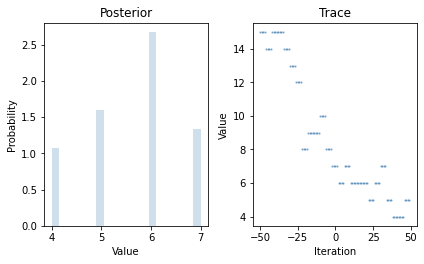

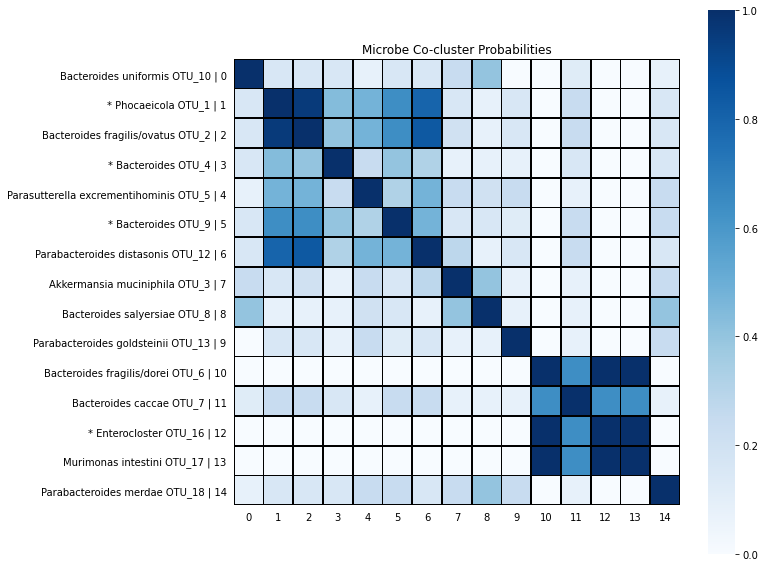

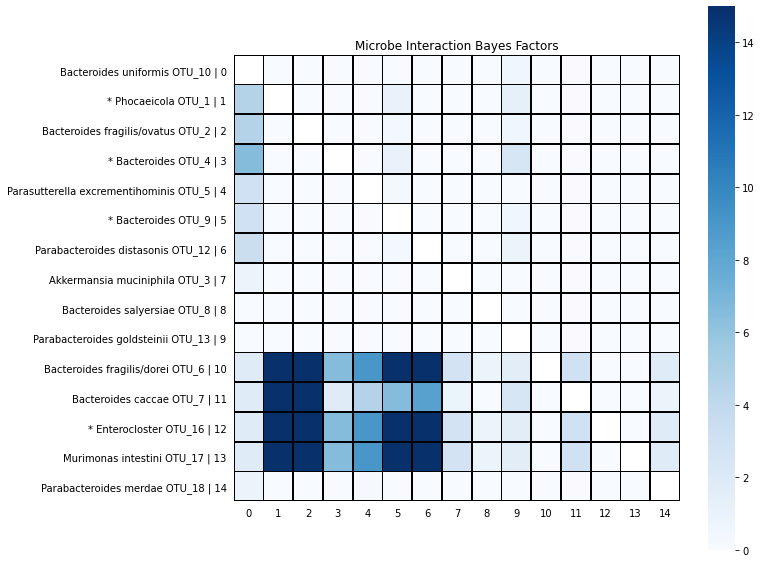

In [20]:
clustering = mcmc_uc1.graph[STRNAMES.CLUSTERING_OBJ]
md2.generate_cluster_assignments_posthoc(clustering, set_as_value=True)
taxas = mcmc_uc1.graph.data.taxas

md2.visualization.render_trace(clustering.n_clusters)
order = []
for i, cluster in enumerate(clustering):
    print('Cluster {}'.format(i))
    for oidx in cluster:
        print('\t', md2.taxaname_for_paper(taxas[oidx], taxas))
        order.append(oidx)

coclusters = md2.summary(mcmc_uc1.graph[STRNAMES.CLUSTERING_OBJ].coclusters)['mean']
md2.visualization.render_cocluster_proportions(
    coclusters, taxas=uc_toy.taxas, yticklabels='%(paperformat)s | %(index)s',
    order=order)

bayes_factors = md2.generate_interation_bayes_factors_posthoc(mcmc_uc1)
md2.visualization.render_bayes_factors(
    bayes_factors, taxas=taxas, yticklabels='%(paperformat)s | %(index)s',
    order=order)

plt.show()

In [21]:
chains = [mcmc_uc0, mcmc_uc1]
start = 10
end = 20
vname = STRNAMES.GROWTH_VALUE

rhat = md2.pylab.inference.r_hat(chains, start=start, end=end, vname=vname, returnBW=True)
print('Growth values:', rhat)

vname = STRNAMES.CONCENTRATION
rhat = md2.pylab.inference.r_hat(chains, start=start, end=end, vname=vname, returnBW=True)
print('Concentration parameter:', rhat)

vname = STRNAMES.PROCESSVAR
rhat = md2.pylab.inference.r_hat(chains, start=start, end=end, vname=vname, returnBW=True)
print('Process variance parameter:', rhat)


Growth values: {'B': array([5.07536850e-02, 4.29649387e-03, 7.41476251e-03, 1.14140468e-03, 4.15802180e-03, 3.75549397e-02, 2.40202258e-02, 2.37601551e-03, 2.12435239e-03, 1.62641295e-04, 1.74131582e-02, 3.96347023e-06, 4.11874804e-03, 1.37894985e-02, 1.78170973e-02]), 'W': array([0.02241619, 0.01729327, 0.02151941, 0.00861838, 0.01116278, 0.02606434, 0.01776725, 0.01219692, 0.00800231, 0.00554016, 0.01254216, 0.00715283, 0.02228537, 0.01592368, 0.02186952]), 'rhat': array([0.1912719 , 0.10389842, 0.12027919, 0.06985623, 0.08752373, 0.17835258, 0.14454667, 0.08536082, 0.0711571 , 0.05339849, 0.12238326, 0.05981971, 0.11490022, 0.1218876 , 0.14086627])}
Concentration parameter: {'B': 164514648.52739567, 'W': 2607453607.7859383, 'rhat': 37228.807772431646}
Process variance parameter: {'B': 0.0030978586368072053, 'W': 0.029024787931751256, 'rhat': 0.12673327615223726}


# Consensus clustering
Run the model with a fixed modules

In [ ]:
# Use the clustering from a previous as the clustering assignment
params = md2.config.MDSINE2ModelConfig(
    basepath=basepath, seed=0, burnin=50, n_samples=100, 
    negbin_a0=a0, negbin_a1=a1, checkpoint=50)

# Do not learn the clustering parameters
params.LEARN[STRNAMES.CLUSTERING] = False
params.LEARN[STRNAMES.CONCENTRATION] = False

# Set the initialization option for clustering
params.INITIALIZATION_KWARGS[STRNAMES.CLUSTERING]['value_option'] = 'fixed-clustering'
params.INITIALIZATION_KWARGS[STRNAMES.CLUSTERING]['value'] = 'output/mdsine2/uc100/mcmc.pkl'

mcmc = md2.initialize_graph(params=params, graph_name=uc_toy.name, subjset=uc_toy)
mcmc = md2.run_graph(mcmc, crash_if_error=True)

In [ ]:
# Plot the posterior
taxas = mcmc.graph.data.taxas

clustering = mcmc.graph[STRNAMES.CLUSTERING_OBJ]
bf_taxa = md2.generate_interation_bayes_factors_posthoc(mcmc)
bf_clustering = md2.condense_fixed_clustering_interaction_matrix(bf_taxa, clustering=clustering)

labels = ['Cluster {} | {}'.format(i+1, i+1) for i in range(len(clustering))]
md2.visualization.render_bayes_factors(bf_clustering, yticklabels=labels)
plt.show()

# Cross validation

Take out a single subject and use that as initial conditions for forward simulation

In [ ]:
# Make the data and validation Study objects
study = md2.dataset.parse(
    name='uc-toy-dataset', 
    taxonomy='data/uc-toy/taxonomy.tsv', 
    reads='data/uc-toy/reads.tsv', 
    qpcr='data/uc-toy/qpcr.tsv', 
    perturbations='data/uc-toy/perturbations.tsv', 
    metadata='data/uc-toy/metadata.tsv')

val = study.pop_subject('8')
val.name += '-validate'

print(study.name)
for subj in study:
    print(subj.name)
for pert in study.perturbations:
    print(pert)
print()
print(val.name)
for subj in val:
    print(subj.name)
for pert in val.perturbations:
    print(pert)


In [ ]:
# Learn the model
params = md2.config.MDSINE2ModelConfig(
    basepath='output/mdsine2/cv/'+study.name, seed=0, 
    burnin=50, n_samples=100, 
    negbin_a0=a0, negbin_a1=a1, checkpoint=50)
params.INITIALIZATION_KWARGS[STRNAMES.CLUSTERING]['value_option'] = 'no-clusters'
mcmc = md2.initialize_graph(params=params, graph_name=study.name, subjset=study)
mcmc = md2.run_graph(mcmc, crash_if_error=True)

In [ ]:
# Forward simulate

# Get the initial conditions
subj = val['8']
M_truth = subj.matrix()['abs']
initial_conditions = M_truth[:,0]
initial_conditions[initial_conditions==0] = 1e5
times = subj.times

# Forward simulate for each gibb step
M = md2.model.gLVDynamicsSingleClustering.forward_sim_from_chain(
    mcmc, val=subj, initial_conditions=initial_conditions, times=times, 
    simulation_dt=0.01)


In [ ]:
# Plot the forward sims, 25th-75th percentile
taxas = subj.taxas

low = np.percentile(M, q=25, axis=0)
high = np.percentile(M, q=75, axis=0)
med = np.percentile(M, q=50, axis=0)

oidx = 3

fig = plt.figure()
ax = fig.add_subplot(111)
ax.fill_between(times, y1=low[oidx, :], y2=high[oidx, :], alpha=0.2)
ax.plot(times, med[oidx,:], label='Forward Sim')
ax.plot(times, M_truth[oidx, :], label='Data', marker='x', color='black',
       linestyle=':')
ax.set_yscale('log')

md2.visualization.shade_in_perturbations(ax, perturbations=subj.perturbations, subj=subj)
ax.set_ylim(bottom=1e5, top=1e12)

ax.legend()

fig.suptitle(md2.taxaname_for_paper(taxas[oidx], taxas))
plt.show()

# Keystoneness
Calculate the keystoneness by using the `MDSINE2_Paper/keystoneness.py` script of the chain `uc100`.

Each line out table indicates which OTUs to leave out for that iteration of forward simulating to the steady state. Note that these are 0-based indecies for the OTUs.

In [ ]:
# Make the leave out table - leave out each Cluster
os.makedirs('output/keystoneness', exist_ok=True)

mcmc = md2.BaseMCMC.load('output/mdsine2/uc100/mcmc.pkl')
clustering = mcmc.graph[STRNAMES.CLUSTERING_OBJ]
md2.generate_cluster_assignments_posthoc(clustering, set_as_value=True)
print(clustering)

txt = '\n'.join([','.join([str(oidx) for oidx in cluster.members]) for cluster in clustering])
f = open('output/keystoneness/leave_out_table.csv', 'w')
f.write(txt)
f.close()
print(txt)

!python ../keystoneness.py \
    --input output/mdsine2/uc0/mcmc.pkl \
    --study output/mdsine2/uc0/subjset.pkl \
    --leave-out-table output/keystoneness/leave_out_table.csv \
    --sep , \
    --simulation-dt 0.01 \
    --output-basepath output/keystoneness/ \
    --n-days 60

In [ ]:
# Display the steady state table
df_steady_state = pd.read_csv('output/keystoneness/uc-toy-dataset/steady-state-table.tsv',
                sep='\t', index_col=0)
df_steady_state.head()

In [ ]:
# Display the keystoneness table
df_keystoneness = pd.read_csv('output/keystoneness/uc-toy-dataset/keystoneness.tsv',
                sep='\t', index_col=0)
df_keystoneness.head()

# Perturbation analysis

In [ ]:
!python ../perturbation_analysis.py \
    --input output/mdsine2/uc0/mcmc.pkl \
    --study output/mdsine2/uc0/subjset.pkl \
    --leave-out-table output/keystoneness/leave_out_table.csv \
    --perturbation Vancomycin \
    --output-basepath output/keystoneness/pert_analysis \
    --start-perturbation 60 \
    --end-perturbation 120 \
    --n-days 180